## CS 5990: Advanced Machine Learning Final Project

Mish Wilson and Cooper Sullivan

10/23/2024

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read, write
from IPython.display import Audio
from numpy.fft import fft, ifft
from os.path import dirname, join as pjoin
from scipy.io import wavfile

import torch
import torchaudio
import torch.nn as nn

import scipy.io 
import os

import csv
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import DataLoader, Dataset, random_split, Subset

%matplotlib inline

import math, random
from pathlib import Path
import soundfile

from itertools import combinations
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn
from torchsummary import summary

In [3]:
# Test to see current working directory w correct files listed
os.listdir()

['$REA7KR4.wav',
 '.git',
 '.gitignore',
 'classID.csv',
 'clips_rd',
 'load.py',
 'metadeta.csv',
 'prelim_results.ipynb',
 'preprocess.py',
 'README.md',
 'requirements.txt',
 'tensor.pt',
 'test_clips',
 'text_zone.ipynb',
 'trash.ipynb']

In [4]:
# Test if we can read single file and get samplerate and data attributes
data_dir = pjoin(os.curdir, '.\clips_rd', 'aloe')
wav_fname = pjoin(data_dir, 'aloe_1_02.wav')
samplerate, data = wavfile.read(wav_fname)
print(f"length = {data.shape[0] / samplerate}s")
print(data.shape)

length = 2.9872562358276644s
(131738,)


<>:2: SyntaxWarning: invalid escape sequence '\c'
<>:2: SyntaxWarning: invalid escape sequence '\c'
C:\Users\trueshiba\AppData\Local\Temp\ipykernel_32240\4114016665.py:2: SyntaxWarning: invalid escape sequence '\c'
  data_dir = pjoin(os.curdir, '.\clips_rd', 'aloe')
C:\Users\trueshiba\AppData\Local\Temp\ipykernel_32240\4114016665.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, data = wavfile.read(wav_fname)


In [5]:
# Read single audio clip with regular IO function and call as audio
Fs, data = read('./clips_rd/aloe/aloe_1_02.wav')

Audio(data, rate=Fs)

C:\Users\trueshiba\AppData\Local\Temp\ipykernel_32240\311687441.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  Fs, data = read('./clips_rd/aloe/aloe_1_02.wav')


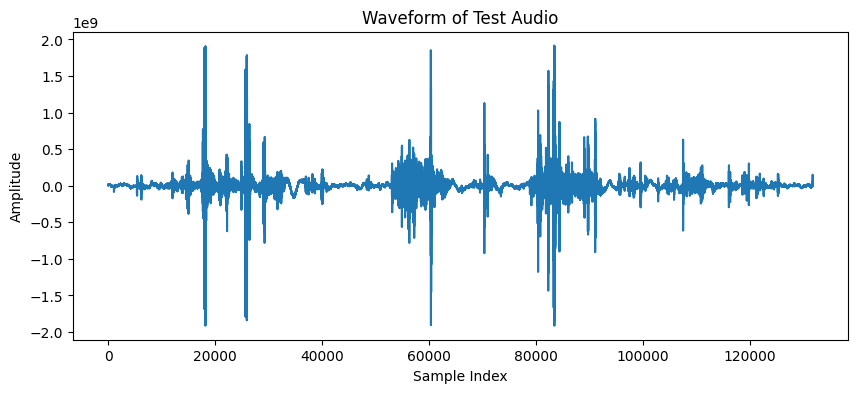

In [6]:
# Plot waveform to better understand visualness of audio
plt.figure(figsize=(10, 4))
plt.plot(data)
plt.xlabel("Sample Index")
plt.ylabel('Amplitude')
plt.title('Waveform of Test Audio')
plt.show()

Each audio sample in the dataset such as its filename, its class label, the ‘fold’ sub-folder location, and so on.

We will create a CSV to store path data for loading. Format: relative_path, classID, label

In [7]:
# Display food labels
path = os.getcwd() + "/clips_rd" 
food_categories = os.listdir(path) 
print("Files and directories in '", path, "' :")  
print(food_categories)

Files and directories in ' c:\Users\trueshiba\Documents\machineLearning\ML-audio-chef/clips_rd ' :
['aloe', 'burger', 'cabbage', 'candied_fruits', 'carrots', 'chips', 'chocolate', 'drinks', 'fries', 'grapes', 'gummies', 'ice-cream', 'jelly', 'noodles', 'pickles', 'pizza', 'ribs', 'salmon', 'soup', 'wings']


In [8]:
# Create general CSV for label referencing

data = [['class', 'classID']]
for i, food in enumerate(food_categories):
    data.append([food, i+1])

# Create file path for the CSV file
csv_file_path = 'classID.csv'

# Open the file in write mode
with open(csv_file_path, mode='w', newline='') as file:
    # Create a csv.writer object
    writer = csv.writer(file)
    # Write data to the CSV file
    writer.writerows(data)

In [9]:
os.getcwd()

'c:\\Users\\trueshiba\\Documents\\machineLearning\\ML-audio-chef'

In [10]:
# Create metadata CSV file to store audio paths as well as ID and labels

data = [['relative_path', 'classID', 'label','video']]
for i, food in enumerate(food_categories):
    path = os.getcwd() + "\\clips_rd\\" + food
    wavs = os.listdir(path)
    for wav in wavs:
        video = wav.split("_")[1]
        if video == "fruits":
            video = wav.split("_")[2]
        data.append([f"./clips_rd/{food}/{wav}",i, food,video])

print(data)

# File path for the CSV file
csv_file_path = 'metadeta.csv'

# Open the file in write mode
with open(csv_file_path, mode='w', newline='') as file:
    # Create a csv.writer object
    writer = csv.writer(file)
    # Write data to the CSV file
    writer.writerows(data)

[['relative_path', 'classID', 'label', 'video'], ['./clips_rd/aloe/aloe_10_01.wav', 0, 'aloe', '10'], ['./clips_rd/aloe/aloe_10_02.wav', 0, 'aloe', '10'], ['./clips_rd/aloe/aloe_10_03.wav', 0, 'aloe', '10'], ['./clips_rd/aloe/aloe_10_04.wav', 0, 'aloe', '10'], ['./clips_rd/aloe/aloe_10_05.wav', 0, 'aloe', '10'], ['./clips_rd/aloe/aloe_10_06.wav', 0, 'aloe', '10'], ['./clips_rd/aloe/aloe_10_07.wav', 0, 'aloe', '10'], ['./clips_rd/aloe/aloe_10_08.wav', 0, 'aloe', '10'], ['./clips_rd/aloe/aloe_10_09.wav', 0, 'aloe', '10'], ['./clips_rd/aloe/aloe_10_10.wav', 0, 'aloe', '10'], ['./clips_rd/aloe/aloe_10_11.wav', 0, 'aloe', '10'], ['./clips_rd/aloe/aloe_10_12.wav', 0, 'aloe', '10'], ['./clips_rd/aloe/aloe_10_13.wav', 0, 'aloe', '10'], ['./clips_rd/aloe/aloe_10_14.wav', 0, 'aloe', '10'], ['./clips_rd/aloe/aloe_10_15.wav', 0, 'aloe', '10'], ['./clips_rd/aloe/aloe_10_16.wav', 0, 'aloe', '10'], ['./clips_rd/aloe/aloe_10_17.wav', 0, 'aloe', '10'], ['./clips_rd/aloe/aloe_10_18.wav', 0, 'aloe', '10'

## Tranforming Data / Audio Files

Here we transform the data so that its in a format the model expects. This can be done during runtime. 

Audio files tend to be large- so we're keeping only the audio file names in our taining data.

Then at run time, as we train the model we'll load the audio data for that bath and then process it. This way we keep audiodata for only one batch in memory at a time reducing the overall strain on system by loading everything in all at once and having to store it all.

Transforms:
- Load Audio file
- Resample and convert to stereo or mono
    - Testing on aloe- so far all the files seem to have 1 channel so no need to convert them!
- resize to fixed length so all the audios are the same length
- audio augmentation time shift
- convert to mel spectogram
- spectogram augmentation. SPECAUGMENTATING TIME!!

Potential audio processing libraries:
- librosa
    - slower that pytorch
    - seems to be used for smaller datasets?
    - usually used for making spectograms- but since pytorch came out with torchaudio it isn't used as much by new learners- usually used by people who are used to the library. 
- pytorch (torchaudio)
    - pretty fast
    - may be better for such a large data set
    - well documented (in my opinion)
    - we'll be using pytorch anyway to processed the spectrogram- so we probably should just use torchaudio??
- audio flux
    - super fast
    - fairly new
    - less digital examples to follow when learning

## Load in Data

In [11]:
torchaudio.set_audio_backend("soundfile")

def open_audio(audio_file):
    signal, sample_rate = torchaudio.load(f"{os.getcwd()}{audio_file}")
    return signal, sample_rate

df = pd.read_csv('metadeta.csv')

# Check if audio file backend exists
# Output should be ['soundfile']. If output is [] then redownload libraries in specific order.
print(torchaudio.list_audio_backends())


['soundfile']


C:\Users\trueshiba\AppData\Local\Temp\ipykernel_32240\242481931.py:1: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")


In [12]:
# Using Open Audio, for now we're just using aloe
audio_files = []

# Keep track incase not all files are correctly loaded
success = 0
fail = 0

for audio in df[df['label'].isin(["aloe", "burger"])]['relative_path']:
    try:
        audio_files.append(open_audio(audio))
        success += 1
    except RuntimeError:
        fail += 1
        print(f"Skipping file: {audio}")
print(f"Successes: {success}\nFails: {fail}")

Successes: 1141
Fails: 0


In [13]:
# Test code to ensure audio loaded correctly

test_signal, test_sr = audio_files[0]

# for audio in audio_files:
#     print(audio[1])

len(test_signal) / test_sr
test_signal.shape

154293 // 1000 * 3000



462000

## Audio Before Transformations

Text(0.5, 1.0, 'Original Waveform')

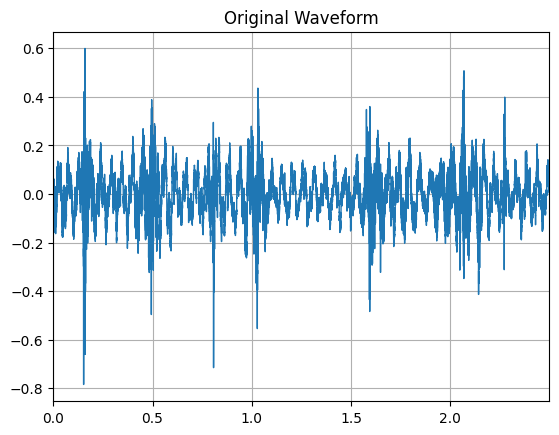

In [14]:
waveform, sr = audio_files[1]
fig, axs = plt.subplots(1, 1)

waveform = waveform.numpy()
num_channels, num_frames = waveform.shape
time_axis = torch.arange(0, num_frames) / sr

ax = axs
ax.plot(time_axis, waveform[0], linewidth=1)
ax.grid(True)
ax.set_xlim([0, time_axis[-1]])
ax.set_title("Original Waveform")

## Transform Sample Rate
Just looping through and making sure all the audio files have the same sample rate! Majority seem to be 44100Hz- but just to make sure I'll loop through to catch any that aren't.

In [15]:
# Resample takes in audio file (aud) and desired sample rate (newsr) and ensures they match
def resample(aud, newsr):
    signal, sr = aud

    if (sr == newsr):
      return audio
        
    # Resample channel
    re_signal = torchaudio.transforms.Resample(sr, newsr)(signal[:1,:])
    

    return ((re_signal, newsr))

In [16]:
# Loop through and resample all audio so its on the same page (44100Hz)
t_audio_files = []
for audio in audio_files:
    t_audio_files.append(resample(audio, 44100))

audio_files = t_audio_files

## Resizing Audio Lengths

Resizing  samples to be the same length. Found that they are infact different lengths ranging between 2 and 4? I think I'll just average it out to 3 seconds each. Padding it out with silence if its 2 seconds and truncating if its 4? We can change this if this is bad.

Math to find length of clips: 
Sample Rate // 44100 Hz 

In [17]:
def resize(aud, max_ms):
    signal, sample_rate = aud
    num_rows, signal_len = signal.shape

    # calculate what would make audio max_ms long
    max_len = sample_rate//1000 * max_ms

    if (signal_len > max_len):
      # Truncate signal
      signal = signal[:,:max_len]

    elif (signal_len < max_len):
      # Pad audio with silence instead. At beginning and end.
      pad_begin_len = random.randint(0, max_len - signal_len)
      pad_end_len = max_len - signal_len - pad_begin_len

      # Pad with 0s
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))

      signal = torch.cat((pad_begin, signal, pad_end), 1)
      
    return (signal, sample_rate)
   

In [18]:
# Loop through and resize all audio so they're all 3 seconds long (3000 miliseconds)
t_audio_files = []
for audio in audio_files:
    t_audio_files.append(resize(audio, 3000))

audio_files = t_audio_files

## Time Shift
Not sure if we need to do this augmentation shince I think we have a pretty diverse dataset? But We can return to this incase we do.

## Mel Spectrogram Creation.

Time to creat some spectrograms! Specifically Mel Spectrograms instead of jsut Spectrograms as they are better for training models it seems.

"The mel-spectrogram, based on the auditory-based mel-frequency scale, provides better resolution for lower frequencies than the spectrogram"

In [19]:
# n_mels : Number of mel filterbanks
# n_fft : Size of FFT
# hop_len : Length of hop between STFT windows
def spectrogram(audio, n_mels=64, n_fft=1024, hop_len=None):
    signal, sample_rate = audio
    top_db = 80

    # spectrogram shape is [channel, n_mels, time]
    spec = transforms.MelSpectrogram(sample_rate, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(signal)

    # Convert to decibels 
    spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
    return spec

In [20]:
spec = spectrogram(audio_files[1])


NameError: name 'transforms' is not defined

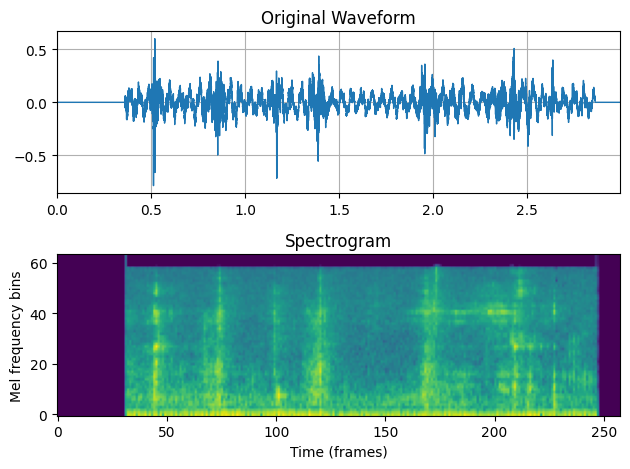

In [21]:
def plot_spectrogram(spec, title='Spectrogram'):
    # Convert the tensor to a numpy array and squeeze to 2D
    spec = spec.squeeze().numpy()

    plt.figure(figsize=(10, 4))
    plt.imshow(spec, aspect='auto', origin='lower')
    plt.colorbar()
    plt.title(title)
    plt.xlabel('Time (frames)')
    plt.ylabel('Mel frequency bins')
    return plt

# plot_spectrogram(spec, title='Spectrogram')

spec = spectrogram(audio_files[1])
waveform, sr = audio_files[1]
fig, axs = plt.subplots(2, 1)

waveform = waveform.numpy()
num_channels, num_frames = waveform.shape
time_axis = torch.arange(0, num_frames) / sr

ax = axs[0]
ax.plot(time_axis, waveform[0], linewidth=1)
ax.grid(True)
ax.set_xlim([0, time_axis[-1]])
ax.set_title("Original Waveform")

s_spec = spec.squeeze().numpy()

ax = axs[1]
ax.imshow(s_spec, aspect='auto', origin='lower')
ax.set_title("Spectrogram")
ax.set_xlabel('Time (frames)')
ax.set_ylabel('Mel frequency bins')

fig.tight_layout()

# SPEC Augmentation
Time and Frequency Masking!

fREQUENCY mASK: Randomly Mask out a range of consecutive frequencies by adding horizonatal bars to our spectro gram

Time Mask: Randomly block out ranges of time from the spectrogram by using vertical bars.

We do this to prevent voerfitting and to help the model generalize better. The masked sections get replaced with a mean value :0 Which is pretty cool!!

In [22]:
spec.shape
# ..., number of mels, number of steps (time)
# Documentation literally says the first index is '...'

torch.Size([1, 64, 258])

In [23]:
# Defaulting to 10% and only one mask until we deiscuss what would 
# be most optional :)
def spec_mask(spec, max_mask_pct=0.1, num_freq_masks=1, num_time_masks=1):
    _, num_mels, num_steps = spec.shape
    
    # Get the average to replace the blocked zones
    mask_val = spec.mean()
    augment_spec = spec
    
    # Add frquency mask- will look like a horizonal bar
    freq_mask_param = max_mask_pct * num_mels
    for _ in range(num_freq_masks):
        augment_spec = transforms.FrequencyMasking(freq_mask_param)(augment_spec, mask_val)

    # Add time mask- will look like a vertical bar
    time_mask_param = max_mask_pct * num_steps
    for _ in range(num_time_masks):
        augment_spec = transforms.TimeMasking(time_mask_param)(augment_spec,mask_val)

    return augment_spec

## Before Masking

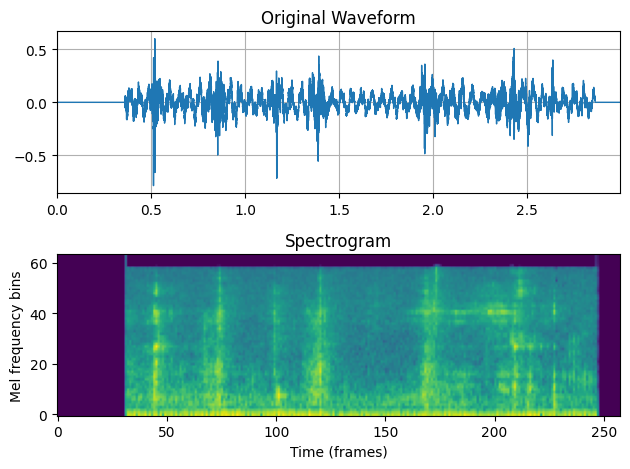

In [24]:
spec = spectrogram(audio_files[1])
waveform, sr = audio_files[1]
fig, axs = plt.subplots(2, 1)

waveform = waveform.numpy()
num_channels, num_frames = waveform.shape
time_axis = torch.arange(0, num_frames) / sr

ax = axs[0]
ax.plot(time_axis, waveform[0], linewidth=1)
ax.grid(True)
ax.set_xlim([0, time_axis[-1]])
ax.set_title("Original Waveform")

s_spec = spec.squeeze().numpy()

ax = axs[1]
ax.imshow(s_spec, aspect='auto', origin='lower')
ax.set_title("Spectrogram")
ax.set_xlabel('Time (frames)')
ax.set_ylabel('Mel frequency bins')

fig.tight_layout()



## After Masking

In [34]:
spec = spectrogram(audio_files[1])
spec = spec_mask(spec)
spec
torch.save(spec, 'tensor.pt')

In [36]:
torch.load('tensor.pt', weights_only=True)

tensor([[[-45.7066, -45.7066, -45.7066,  ..., -45.7066, -45.7066, -45.7066],
         [-45.7066, -45.7066, -45.7066,  ..., -45.7066, -45.7066, -45.7066],
         [-45.7066, -45.7066, -45.7066,  ..., -45.7066, -45.7066, -45.7066],
         ...,
         [-45.7066, -45.7066, -45.7066,  ..., -45.7066, -45.7066, -45.7066],
         [-45.7066, -45.7066, -45.7066,  ..., -45.7066, -45.7066, -45.7066],
         [-45.7066, -45.7066, -45.7066,  ..., -45.7066, -45.7066, -45.7066]]])

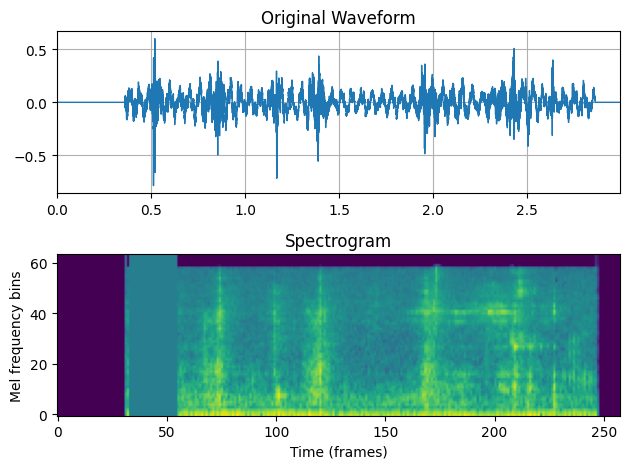

In [26]:
waveform, sr = audio_files[1]
fig, axs = plt.subplots(2, 1)

waveform = waveform.numpy()
num_channels, num_frames = waveform.shape
time_axis = torch.arange(0, num_frames) / sr

ax = axs[0]
ax.plot(time_axis, waveform[0], linewidth=1)
ax.grid(True)
ax.set_xlim([0, time_axis[-1]])
ax.set_title("Original Waveform")

s_spec = spec.squeeze().numpy()

ax = axs[1]
ax.imshow(s_spec, aspect='auto', origin='lower')
ax.set_title("Spectrogram")
ax.set_xlabel('Time (frames)')
ax.set_ylabel('Mel frequency bins')

fig.tight_layout()

# Data Loader for Model
- dataset Object that tranforms the audio- preping each data item
- DataLoader from torch- to fecth the sata items and packages them to batches

In [27]:
# Group together audio opening function as well as audio transformation functions into a convenient class
class AudioFuncs():
    
    def open_audio(audio_file):
        signal, sample_rate = torchaudio.load(audio_file)
        return signal, sample_rate


    # Resample takes in audio file (aud) and desired sample rate (newsr) and ensures they match
    def resample(aud, newsr):
        signal, sr = aud

        if (sr == newsr):
            return aud
            
        # Resample channel
        re_signal = torchaudio.transforms.Resample(sr, newsr)(signal[:1,:])
    
        return ((re_signal, newsr))


    # Resize audio to be of specific time length (max_ms)
    def resize(aud, max_ms):
        signal, sample_rate = aud
        num_rows, signal_len = signal.shape

        # calculate what would make audio max_ms long
        max_len = sample_rate//1000 * max_ms

        if (signal_len > max_len):
            # Truncate signal
            signal = signal[:,:max_len]

        elif (signal_len < max_len):
            # Pad audio with silence instead. At beginning and end.
            pad_begin_len = random.randint(0, max_len - signal_len)
            pad_end_len = max_len - signal_len - pad_begin_len

            # Pad with 0s
            pad_begin = torch.zeros((num_rows, pad_begin_len))
            pad_end = torch.zeros((num_rows, pad_end_len))

            signal = torch.cat((pad_begin, signal, pad_end), 1)
        
        return (signal, sample_rate)
    
    # Rechannel audio
    def rechannel(audio, max_channels):
        
        signal, sr = audio

        # Verify audio isn't already correct number of channels 
        if (signal.shape[0] == max_channels):
            return audio
        
        # If audio channels > max_channels -> Reduce channels to max_channels
        if (signal.shape[0] > max_channels):
            new_signal = signal[:max_channels, :]
            
        else:
             # If audio channels < max_channels -> Add extra channels to reach max_channels
            num_current_channels = signal.shape[0]
            num_channels_to_add = max_channels - num_current_channels
            
            # Calculate full duplications and the remaining channels needed
            full_duplications = num_channels_to_add // num_current_channels
            remaining_channels = num_channels_to_add % num_current_channels

            # Duplicate the signal for full duplications
            new_signal = torch.cat([signal] * (full_duplications + 1), dim=0)

            # Add the remaining channels (if any) by slicing from the original signal
            if remaining_channels > 0:
                new_signal = torch.cat([new_signal, signal[:remaining_channels, :]], dim=0)

        return (new_signal[:max_channels, :], sr)


    # Creates spectrogram for given audio sample with specified mel bins and Fourier transformations.
    def spectrogram(audio, n_mels=128, n_fft=1024, hop_len=None):
        signal, sample_rate = audio
        top_db = 80

        # spectrogram shape is [channel, n_mels, time]
        spec = torchaudio.transforms.MelSpectrogram(sample_rate, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(signal)

        # Convert to decibels 
        spec = torchaudio.transforms.AmplitudeToDB(top_db=top_db)(spec)
        return spec
    

    # Visualize given spectrogram (spec) with matplotlib
    def plot_spectrogram(spec, title='Spectrogram'):
        # Convert the tensor to a numpy array and squeeze to 2D
        spec = spec.squeeze().numpy()

        plt.figure(figsize=(10, 4))
        plt.imshow(spec, aspect='auto', origin='lower')
        plt.colorbar()
        plt.title(title)
        plt.xlabel('Time (frames)')
        plt.ylabel('Mel frequency bins')
        return plt
    

    # Mask a percentage of the given spectrogram with averaging data to in theory reduce overfitting when training data. 
    # Defaulting to 10% and only one mask until we deiscuss what would be most optional for generalizing :)
    def spec_mask(spec, max_mask_pct=0.1, num_freq_masks=1, num_time_masks=1):
        _, num_mels, num_steps = spec.shape
        
        # Get the average to replace the blocked zones
        mask_val = spec.mean()
        augment_spec = spec
        
        # Add frquency mask- will look like a horizonal bar
        freq_mask_param = max_mask_pct * num_mels
        for _ in range(num_freq_masks):
            augment_spec = torchaudio.transforms.FrequencyMasking(freq_mask_param)(augment_spec, mask_val)

        # Add time mask- will look like a vertical bar
        time_mask_param = max_mask_pct * num_steps
        for _ in range(num_time_masks):
            augment_spec = torchaudio.transforms.TimeMasking(time_mask_param)(augment_spec,mask_val)

        return augment_spec


In [37]:
class FoodAudioDS(Dataset):
    def __init__(self, df, dir_path, transform=None, target_transform=None):
        self.df = df
        self.dir_path = dir_path
        #self.transform = transform
        #self.target_transform = target_transform

        self.duration = 3000
        self.sample_rate = 44100
        self.channel = 1

    def __len__(self):
        return len(self.df)  

    def __getitem__(self, idx):

        # Get the Audio file location- using curr directory path and then files
        # relative path

        audio_file = self.dir_path + self.df.loc[idx, 'relative_path']
        
        # Get the Class ID
        class_id = self.df.loc[idx, 'classID']

        aud = AudioFuncs.open_audio(audio_file)
        
        # Tranformations for Audio
        reaud = AudioFuncs.resample(aud, self.sample_rate)
        rechan = AudioFuncs.rechannel(reaud, self.channel)
        dur_aud = AudioFuncs.resize(reaud, self.duration)

        # Create and Transform Spectrogram
        sgram = AudioFuncs.spectrogram(dur_aud, n_mels=64, n_fft=1024, hop_len=None)
        #sgram = AudioFuncs.spec_mask(sgram, max_mask_pct=0.1, num_freq_masks=1, num_time_masks=1)

        # Return spectrogram and classID
        return aug_sgram, class_id

In [42]:
dir_path = os.getcwd()

# Get the total number of samples
# total_samples = len(df)
# subset_size = round(total_samples * 0.1)
# subset_indices = random.sample(range(total_samples), subset_size)
# df_subset = df.iloc[subset_indices].reset_index(drop=True)

# Create a FoodAudioDS instance with the reduced DataFrame
food_ds = FoodAudioDS(df, dir_path)

#food_ds = FoodAudioDS(df, dir_path)
#food_ds = FoodAudioDS(df[df['label'] == 'aloe'], dir_path)


# split data 80:20 between training and validation
num_items = len(food_ds)
num_train_data = round(num_items * 0.8)
num_test = num_items - num_train_data
train_ds, test_ds = random_split(food_ds, [num_train_data, num_test])

# training and validation data loaders
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=128, shuffle=False)

In [39]:
len(food_ds)

1114

## CNN Model
blah blah blah


In [43]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

class CNN_Model(nn.Module):
    def __init__(self, num_classes=20):
        super().__init__()
        self.conv1=nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32,kernel_size=3,stride=1,padding=1),
            ## Normalize
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
            
        )
        self.conv2=nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,stride=1,padding=1),
            ## Normalize
            nn.ReLU(),
            nn.BatchNorm2d(64),
            
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.Dropout(0.5)
        )
        self.conv3=nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128,kernel_size=3,stride=1,padding=1),
            ## Normalize
            nn.ReLU(),
            nn.BatchNorm2d(128),
            
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        )
        self.conv4=nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256,kernel_size=3,stride=1,padding=1),
            ## Normalize
            nn.ReLU(),
            nn.BatchNorm2d(256),
            
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Dropout(0.5) 
        )
        self.flatten=nn.Flatten()
        self.fc1=nn.Sequential(
            nn.Linear(256, 128),  # Reduced feature dimensions
            nn.ReLU(),
            #nn.Dropout(0.05)  # Final dropout before the last layer
        )
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x: torch.Tensor):
            x = self.conv1(x)
            x = self.conv2(x)
            x = self.conv3(x)
            x = self.conv4(x)
            x = self.flatten(x)
            x = self.fc1(x)
            try:
                x = self.fc2(x)
            except Exception as e:
                print(f"Error : Linear block should take support shape of {x.shape} for in_features.")
            return x

                
food_model = CNN_Model()

if torch.cuda.is_available():
     food_model.cuda()

print("Model summary : ")
print(summary(food_model, (1, 64, 258)))

Model summary : 
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 64, 258]             320
              ReLU-2          [-1, 32, 64, 258]               0
       BatchNorm2d-3          [-1, 32, 64, 258]              64
         MaxPool2d-4          [-1, 32, 32, 129]               0
           Dropout-5          [-1, 32, 32, 129]               0
            Conv2d-6          [-1, 64, 32, 129]          18,496
              ReLU-7          [-1, 64, 32, 129]               0
       BatchNorm2d-8          [-1, 64, 32, 129]             128
         MaxPool2d-9           [-1, 64, 16, 64]               0
          Dropout-10           [-1, 64, 16, 64]               0
           Conv2d-11           [-1, 64, 16, 64]          36,928
             ReLU-12           [-1, 64, 16, 64]               0
      BatchNorm2d-13           [-1, 64, 16, 64]             128
        MaxPool2d-14  

## Code for training model

Training set: 7798 samples
Validation set: 2228 samples
Test set: 1114 samples
Initializing training process...
Model moved to CUDA.
Setting up loss function, optimizer, and learning rate scheduler.
Starting training loop...
Epoch 1/10...
Processing batch 1/140...
[Epoch: 1, Batch_Idx: 1, Accuracy: 0.094] loss: 2.927
Processing batch 2/140...
[Epoch: 1, Batch_Idx: 2, Accuracy: 0.078] loss: 2.944
Processing batch 3/140...
[Epoch: 1, Batch_Idx: 3, Accuracy: 0.094] loss: 2.926
Processing batch 4/140...
[Epoch: 1, Batch_Idx: 4, Accuracy: 0.086] loss: 2.929
Processing batch 5/140...
[Epoch: 1, Batch_Idx: 5, Accuracy: 0.094] loss: 2.931
Processing batch 6/140...
[Epoch: 1, Batch_Idx: 6, Accuracy: 0.089] loss: 2.939
Processing batch 7/140...
[Epoch: 1, Batch_Idx: 7, Accuracy: 0.092] loss: 2.939
Processing batch 8/140...
[Epoch: 1, Batch_Idx: 8, Accuracy: 0.084] loss: 2.942
Processing batch 9/140...
[Epoch: 1, Batch_Idx: 9, Accuracy: 0.087] loss: 2.947
Processing batch 10/140...
[Epoch: 1, Bat

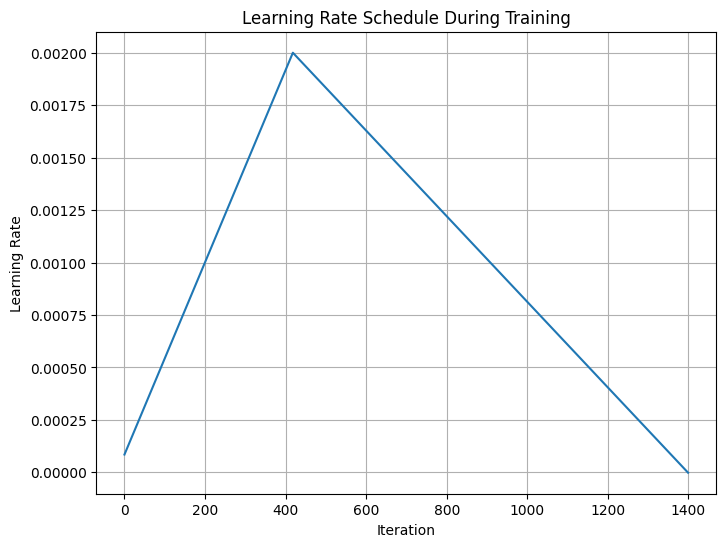

In [45]:
import os
from torch.utils.data import DataLoader, random_split

# Path and dataset initialization
dir_path = os.getcwd()
food_ds = FoodAudioDS(df, dir_path)

# Split data into train, validation, and test sets (70%, 20%, 10%)
num_items = len(food_ds)
num_train_data = round(num_items * 0.7)
num_val_data = round(num_items * 0.2)
num_test_data = num_items - num_train_data - num_val_data

# Random split
g1 = torch.Generator().manual_seed(42)  # For reproducibility
train_ds, val_ds, test_ds = random_split(food_ds, [num_train_data, num_val_data, num_test_data], generator=g1)

# DataLoader initialization
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=16, shuffle=False)

print(f"Training set: {len(train_ds)} samples")
print(f"Validation set: {len(val_ds)} samples")
print(f"Test set: {len(test_ds)} samples")

# Use train_and_plot for training and evaluation
train_and_plot(food_model, train_dl, val_dl, num_epoch=5)


In [160]:
from sklearn.model_selection import GroupShuffleSplit
from torch.utils.data import Subset

# Example: Grouping by speaker ID or another identifier
groups = [food_ds.group_by(i,'video') for i in range(len(food_ds))]  # Replace 'speaker_id' with the correct field

# Grouped split into training (70%), validation (20%), and test (10%)
gss = GroupShuffleSplit(n_splits=1, train_size=0.7, test_size=0.3, random_state=42)
train_idx, temp_idx = next(gss.split(range(len(food_ds)), groups=groups))

val_test_groups = [groups[i] for i in temp_idx]
gss_val_test = GroupShuffleSplit(n_splits=1, train_size=0.67, test_size=0.33, random_state=42)
val_idx, test_idx = next(gss_val_test.split(temp_idx, groups=val_test_groups))

# Subsets for train, validation, and test
train_ds = Subset(food_ds, train_idx)
val_ds = Subset(food_ds, val_idx)
test_ds = Subset(food_ds, test_idx)

# DataLoader initialization
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=16, shuffle=False)

print(f"Training set: {len(train_ds)} samples")
print(f"Validation set: {len(val_ds)} samples")
print(f"Test set: {len(test_ds)} samples")

            print('[Epoch: %d, Batch_Idx: %d, Accuracy: %.3f] loss: %.3f' % (epoch + 1, batch_idx + 1, correct_prediction / total_prediction, running_loss / (batch_idx + 1)))

        # Print stats
        num_batches = len(train_loader)
        avg_loss = running_loss / num_batches
        accuracy = correct_prediction / total_prediction
        print(f"Epoch {epoch + 1} complete. Loss: {avg_loss:.2f}, Accuracy: {accuracy:.2f}")

    print("Training process complete!")

    # Plot the learning rate schedule
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(lrs)), lrs)
    plt.xlabel("Iteration")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rate Schedule During Training")
    plt.grid(True)
    plt.show()


train(food_model, train_dl, num_epoch=10)

Training set: 7809 samples
Validation set: 2355 samples
Test set: 976 samples
Initializing training process...
Epoch 1/5...


KeyboardInterrupt: 

In [ ]:
def train_and_evaluate(model, train_loader, val_loader, num_epochs, class_labels):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

        # Print stats
        num_batches = len(train_loader)
        avg_loss = running_loss / num_batches
        accuracy = correct_prediction / total_prediction
        print(f"Epoch {epoch + 1} complete. Loss: {avg_loss:.2f}, Accuracy: {accuracy:.2f}")

    print("Training process complete!")

    # Plot the learning rate schedule
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(lrs)), lrs)
    plt.xlabel("Iteration")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rate Schedule During Training")
    plt.grid(True)
    plt.show()


            optimizer.zero_grad()

            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # scheduler.step()

            # calculate prediction and loss metrics
            running_loss += loss.item()
            _, predictions = torch.max(outputs, 1)
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)

        train_accuracy = correct_predictions / total_predictions
        train_accuracies.append(train_accuracy)

        # validate loop
        val_accuracy = evaluate(model, val_loader, device)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Plot accuracy
    plot_accuracies(train_accuracies, val_accuracies, num_epochs)

def evaluate(model, data_loader, device):
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        # loop through validation data points and pass them into the model
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)

    return correct_predictions / total_predictions

def plot_accuracies(train_accuracies, val_accuracies, num_epochs):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid()
    plt.show()


Training set: 7798 samples
Validation set: 2228 samples
Test set: 1114 samples
Epoch 1/10, Loss: 1278.6611, Train Accuracy: 0.1783, Val Accuracy: 0.1786
Epoch 2/10, Loss: 1263.8008, Train Accuracy: 0.1833, Val Accuracy: 0.1750
Epoch 3/10, Loss: 1262.6412, Train Accuracy: 0.1918, Val Accuracy: 0.1858
Epoch 4/10, Loss: 1266.0919, Train Accuracy: 0.1903, Val Accuracy: 0.1750
Epoch 5/10, Loss: 1260.8956, Train Accuracy: 0.1886, Val Accuracy: 0.1692
Epoch 6/10, Loss: 1263.5505, Train Accuracy: 0.1836, Val Accuracy: 0.1849
Epoch 7/10, Loss: 1264.5986, Train Accuracy: 0.1820, Val Accuracy: 0.1809
Epoch 8/10, Loss: 1263.6924, Train Accuracy: 0.1899, Val Accuracy: 0.1786
Epoch 9/10, Loss: 1266.2752, Train Accuracy: 0.1841, Val Accuracy: 0.1706
Epoch 10/10, Loss: 1267.4652, Train Accuracy: 0.1879, Val Accuracy: 0.1715


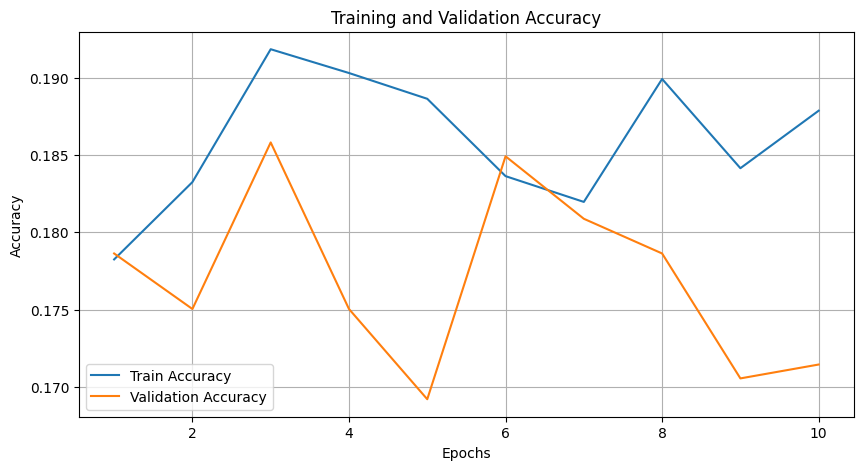

Test Accuracy: 0.1589


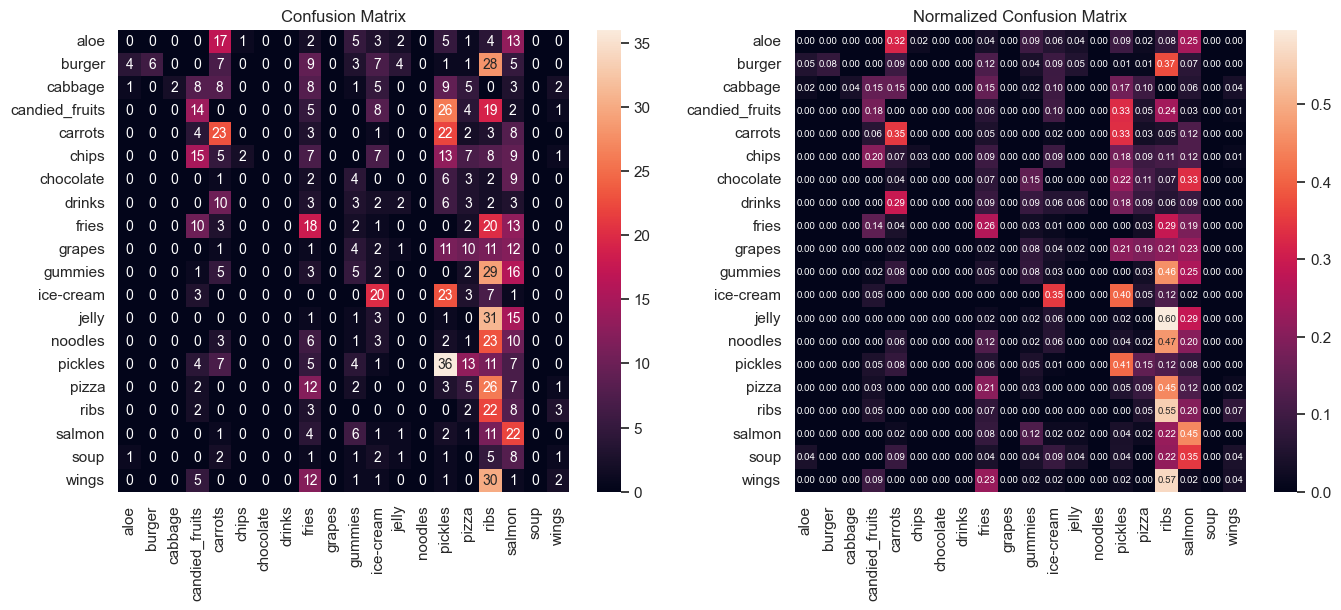

In [ ]:
# Path and dataset initialization
dir_path = os.getcwd()
food_ds = FoodAudioDS(df, dir_path)

unique_labels = df['label'].unique()
assert len(unique_labels) == 20, "Dataset must contain exactly 20 classes!"

# Map labels to index
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
df['label_index'] = df['label'].map(label_to_index)

# Split data into train, validation, and test sets (70%, 20%, 10%)
num_items = len(food_ds)
num_train_data = round(num_items * 0.7)
num_val_data = round(num_items * 0.2)
num_test_data = num_items - num_train_data - num_val_data

# Random split with generator for repro- uhhh 
g1 = torch.Generator().manual_seed(42) 
train_ds, val_ds, test_ds = random_split(food_ds, [num_train_data, num_val_data, num_test_data], generator=g1)

train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=16, shuffle=False)

print(f"Training set: {len(train_ds)} samples")
print(f"Validation set: {len(val_ds)} samples")
print(f"Test set: {len(test_ds)} samples")

# train
train_and_evaluate(food_model, train_dl, val_dl, num_epochs=10, class_labels=unique_labels)

# test
test_model(food_model, test_dl, class_labels=unique_labels)


#### Grouped Split

Train split contains all labels.
Test split contains all labels.
Training set: 7556 samples
Validation set: 2776 samples
Test set: 808 samples
Epoch 1/10, Loss: 1205.0645, Train Accuracy: 0.2111, Val Accuracy: 0.1383
Epoch 2/10, Loss: 1185.8918, Train Accuracy: 0.2168, Val Accuracy: 0.1272
Epoch 3/10, Loss: 1186.2227, Train Accuracy: 0.2160, Val Accuracy: 0.1221
Epoch 4/10, Loss: 1185.1845, Train Accuracy: 0.2226, Val Accuracy: 0.1153
Epoch 5/10, Loss: 1186.2085, Train Accuracy: 0.2200, Val Accuracy: 0.1351
Epoch 6/10, Loss: 1184.7702, Train Accuracy: 0.2209, Val Accuracy: 0.1221
Epoch 7/10, Loss: 1186.8446, Train Accuracy: 0.2176, Val Accuracy: 0.1236
Epoch 8/10, Loss: 1182.6430, Train Accuracy: 0.2234, Val Accuracy: 0.1272
Epoch 9/10, Loss: 1189.0470, Train Accuracy: 0.2135, Val Accuracy: 0.1232
Epoch 10/10, Loss: 1184.5676, Train Accuracy: 0.2200, Val Accuracy: 0.1282


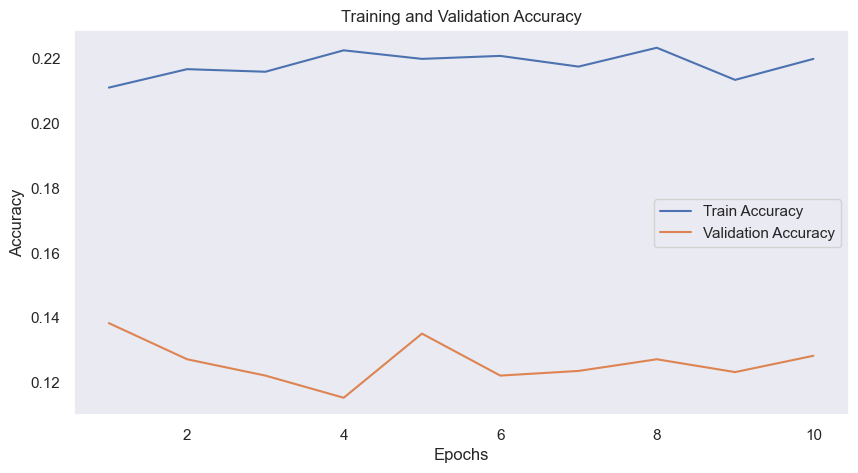

Test Accuracy: 0.1188


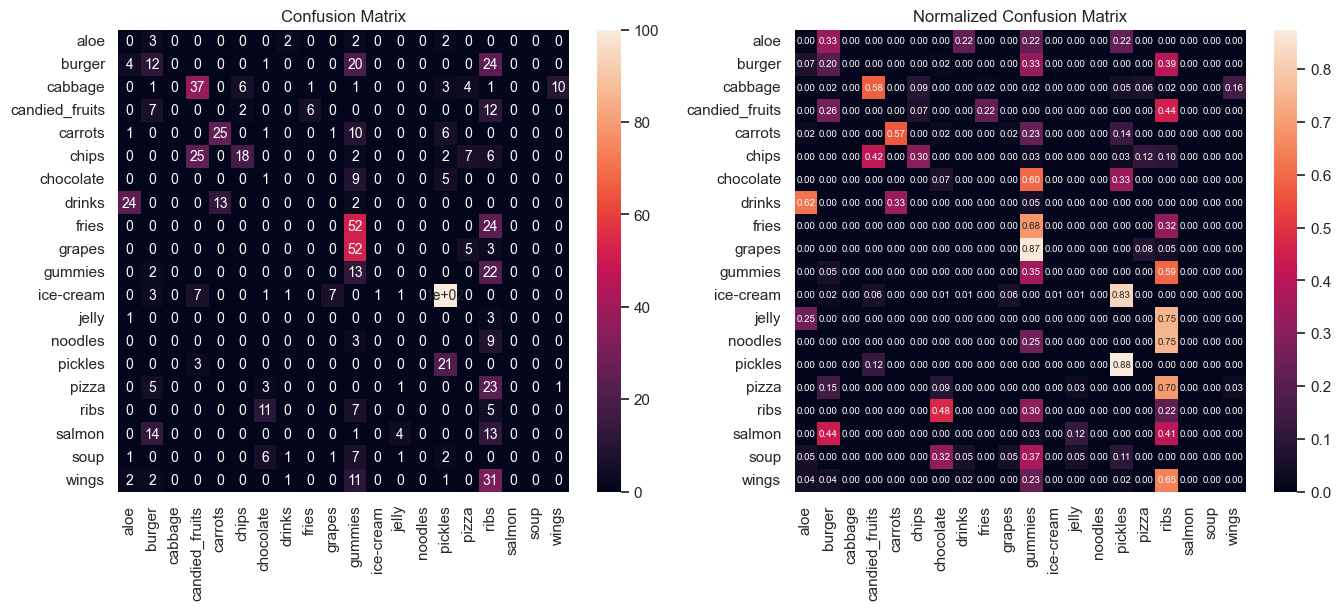

In [ ]:
# Path and dataset initialization
dir_path = os.getcwd()
food_ds = FoodAudioDS(df, dir_path)

# Ensure dataset contains 20 unique labels
unique_labels = df['label'].unique()
assert len(unique_labels) == 20, "Dataset must contain exactly 20 classes!"

# Map labels to indices
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
df['label_index'] = df['label'].map(label_to_index)

# Function to perform grouped split for each label
def grouped_holdout_split(df, train_size=0.7, random_state=42):
    train_indices, val_indices = [], []

    for label in df['label'].unique():
        # Filter rows for the current label
        label_df = df[df['label'] == label]
        
        # Use 'video' column as the grouping variable
        groups = label_df['video'].tolist()

        # Perform grouped split
        gss = GroupShuffleSplit(n_splits=1, test_size=0.05, train_size=0.7, random_state=random_state)
        label_train_idx, label_val_idx = next(gss.split(label_df, groups=groups))

        # Append the global indices to train and validation lists
        train_indices.extend(label_df.iloc[label_train_idx].index.tolist())
        val_indices.extend(label_df.iloc[label_val_idx].index.tolist())

    return train_indices, val_indices

# Perform the grouped split
train_idx, test_idx = grouped_holdout_split(df)

# Ensure all labels are present in both splits
def verify_label_coverage(df, indices, split_name):
    labels_in_split = df.iloc[indices]['label'].unique()
    missing_labels = set(df['label'].unique()) - set(labels_in_split)
    assert not missing_labels, f"{split_name} split is missing labels: {missing_labels}"
    print(f"{split_name} split contains all labels.")

verify_label_coverage(df, train_idx, "Train")
verify_label_coverage(df, test_idx, "Test")

# Create subsets for train and validation
train_ds = Subset(food_ds, train_idx)
test_ds = Subset(food_ds, test_idx)

# Test set (use remaining data not in train or val for test)
val_idx = list(set(df.index) - set(train_idx) - set(test_idx))
val_ds = Subset(food_ds, val_idx)

# DataLoader initialization
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=16, shuffle=False)

# Display dataset sizes
print(f"Training set: {len(train_ds)} samples")
print(f"Validation set: {len(val_ds)} samples")
print(f"Test set: {len(test_ds)} samples")

# Train the model
train_and_evaluate(food_model, train_dl, val_dl, num_epochs=10, class_labels=unique_labels)

# Test the model
test_model(food_model, test_dl, class_labels=unique_labels)


### Pairwise Evaluation

In [20]:
class FoodAudioPairDS(Dataset):
    def __init__(self, df, dir_path):
        self.df = df
        self.dir_path = dir_path
        self.cache = {}

        self.duration = 3000
        self.sample_rate = 44100
        self.channel = 1

    def __len__(self):
        return len(self.df)  

    def __getitem__(self, idx):
        if idx in self.cache:
            sgram = AudioFuncs.spec_mask(self.cache[idx][0], max_mask_pct=0.1, num_freq_masks=1, num_time_masks=1)
            return sgram,self.cache[idx][1]

        # Get the Audio file location- using curr directory path and then files
        # relative path

        audio_file = self.dir_path + self.df.loc[idx, 'relative_path']
        
        # Get the Class ID
        class_id = self.df.loc[idx, 'binary_label']

        aud = AudioFuncs.open_audio(audio_file)
        
        # Tranformations for Audio
        reaud = AudioFuncs.resample(aud, self.sample_rate)
        rechan = AudioFuncs.rechannel(reaud, self.channel)
        dur_aud = AudioFuncs.resize(rechan, self.duration)

        # Create and Transform Spectrogram
        sgram = AudioFuncs.spectrogram(dur_aud, n_mels=64, n_fft=1024, hop_len=None)
        self.cache[idx] = (sgram, class_id)
        sgram = AudioFuncs.spec_mask(sgram, max_mask_pct=0.1, num_freq_masks=1, num_time_masks=1)

        # Return spectrogram and classID
        return sgram, class_id
    
    def group_by(self, idx, column):
        return df.loc[idx][column]

In [25]:
torch.cuda.is_available()

True

In [21]:
def get_pairwise_dataset(df, label1, label2, dir_path):
   # Filter the dataset for the two labels
    pairwise_df = df[df['label'].isin([label1, label2])].copy()

    # Map labels to binary values: label1 -> 0, label2 -> 1
    label_map = {label1: 0, label2: 1}
    pairwise_df['binary_label'] = pairwise_df['label'].map(label_map)

    # Extract group information (e.g., speaker_id or session_id)
    groups = pairwise_df['video'].tolist()  

    # Create the pairwise dataset
    pairwise_ds = FoodAudioPairDS(pairwise_df, dir_path)

    return pairwise_df, pairwise_ds, groups

def grouped_split(df, pairwise, pairwise_ds, groups):
    train_idx, test_idx, val_idx = [], [], []

    for label in pairwise:
        # Filter rows for the current label
        label_df = df[df['label'] == label]
        
        # Use 'video' column as the grouping variable
        groups = label_df['video'].tolist()

        # Perform grouped split
        gss = GroupShuffleSplit(n_splits=1, test_size=0.1, train_size=0.7, random_state=42)
        label_train_idx, label_val_idx = next(gss.split(label_df, groups=groups))

        # Append the global indices to train and validation lists
        train_idx.extend(label_df.iloc[label_train_idx].index.tolist())
        val_idx.extend(label_df.iloc[label_val_idx].index.tolist())
        test_idx = list(set(label_df.index) - set(train_idx) - set(val_idx))
    
    
    train_ds = Subset(pairwise_ds, train_idx)
    test_ds = Subset(pairwise_ds, test_idx)

    # Test set (use remaining data not in train or val for test)
    val_ds = Subset(pairwise_ds, val_idx)

    # DataLoader initialization
    train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=16, shuffle=False)
    test_dl = DataLoader(test_ds, batch_size=16, shuffle=False)
    
    print(f"Training set: {len(train_ds)} samples")
    print(f"Validation set: {len(val_ds)} samples")
    print(f"Test set: {len(test_ds)} samples")
    print("=====================================\n")

    return train_dl, val_dl, test_dl


def train_and_evaluate_pairwise(model, train_loader, val_loader, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()  # Use binary labels (0, 1) but still apply CrossEntropyLoss
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=num_epochs,
        anneal_strategy='cos'
    )

    # metrics!!
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}...")
        # Training loop
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(torch.device("cuda")), labels.to(device)

            #assert inputs.device == device, "Inputs are not on the correct device!"
            #assert labels.device == device, "Labels are not on the correct device!"

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Metrics
            running_loss += loss.item()


            _, predictions = torch.max(outputs, 1)
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += predictions.shape[0]

            #print('[Epoch: %d, Batch_Idx: %d, Accuracy: %.3f] loss: %.3f' % (epoch + 1, batch_idx + 1, correct_predictions / total_predictions, running_loss / (batch_idx + 1)))

        train_accuracy = correct_predictions / total_predictions

        # Validation loop
        val_accuracy = evaluate(model, val_loader, device)
        # print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")

    return train_accuracy, val_accuracy


# Evaluate model on test set
def evaluate(model, data_loader, device):
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)

    return correct_predictions / total_predictions


def pairwise_classification_with_groups(df, dir_path, num_epochs):
    labels = df['label'].unique()
    results = {}

    unique_labels = df['label'].unique()
    assert len(unique_labels) == 20, "Dataset must contain exactly 20 classes!"

    pairwise_model = CNN_Model(num_classes=2)
    
    for label1, label2 in combinations(labels, 2):
        print(f"Training pairwise model for: {label1} vs {label2}")

        # Create pairwise dataset with groups
        pairwise_df, pairwise_ds, groups = get_pairwise_dataset(df, label1, label2, dir_path)
        #print("=======Pairewise Dataframe===============")
        

        # Perform grouped split
        train_dl, val_dl, test_dl = grouped_split(df, [label1, label2], pairwise_ds, groups)

        # Initialize a new model for each pair
        

        # Train and evaluate
        train_acc, val_acc = train_and_evaluate_pairwise(pairwise_model, train_dl, val_dl, num_epochs)

        # Test model
        test_acc = evaluate(pairwise_model, test_dl, torch.device("cuda" if torch.cuda.is_available() else "cpu"))

        # Save results
        results[(label1, label2)] = {
            "train_accuracy": train_acc,
            "val_accuracy": val_acc,
            "test_accuracy": test_acc
        }

        print(f"Results for {label1} vs {label2}: Train Accuracy = {train_acc:.4f}, Val Accuracy = {val_acc:.4f}, Test Accuracy = {test_acc:.4f}\n")

    return results



In [34]:
# Path and dataset initialization
dir_path = os.getcwd()
food_ds = FoodAudioDS(df, dir_path)

unique_labels = df['label'].unique()
assert len(unique_labels) == 20, "Dataset must contain exactly 20 classes!"


# Run pairwise classification with grouped splits
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

results = pairwise_classification_with_groups(df, os.getcwd(), num_epochs=5)

# Print summary of results
for pair, metrics in results.items():
    print(f"Pair: {pair}, Train Accuracy: {metrics['train_accuracy']:.4f}, Val Accuracy: {metrics['val_accuracy']:.4f}, Test Accuracy: {metrics['test_accuracy']:.4f}")

Training pairwise model for: aloe vs burger
Training set: 873 samples
Validation set: 131 samples
Test set: 64 samples

Epoch 1/5...
Epoch 2/5...
Epoch 3/5...
Epoch 4/5...
Epoch 5/5...
Results for aloe vs burger: Train Accuracy = 0.9473, Val Accuracy = 0.9084, Test Accuracy = 0.9688

Training pairwise model for: aloe vs cabbage
Training set: 825 samples
Validation set: 94 samples
Test set: 53 samples

Epoch 1/5...
Epoch 2/5...
Epoch 3/5...
Epoch 4/5...
Epoch 5/5...
Results for aloe vs cabbage: Train Accuracy = 0.9539, Val Accuracy = 0.8511, Test Accuracy = 0.4151

Training pairwise model for: aloe vs candied_fruits
Training set: 987 samples
Validation set: 174 samples
Test set: 118 samples

Epoch 1/5...
Epoch 2/5...
Epoch 3/5...
Epoch 4/5...
Epoch 5/5...
Results for aloe vs candied_fruits: Train Accuracy = 0.9645, Val Accuracy = 1.0000, Test Accuracy = 0.7542

Training pairwise model for: aloe vs carrots
Training set: 919 samples
Validation set: 124 samples
Test set: 90 samples

Epoch 

KeyboardInterrupt: 

In [22]:
def pairwise_classification_with_groups(df, dir_path, num_epochs):
    labels = df['label'].unique()
    results = {}
    confusion_data = {}

    unique_labels = df['label'].unique()
    assert len(unique_labels) == 20, "Dataset must contain exactly 20 classes!"

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize a single model to be trained on all pairs
    pairwise_model = CNN_Model(num_classes=2).to(device)
    test_horde = []

    # Train the model on all pair combinations
    for label1, label2 in combinations(labels, 2):
        print(f"Training on pair: {label1} vs {label2}")

        # Create pairwise dataset with groups
        pairwise_df, pairwise_ds, groups = get_pairwise_dataset(df, label1, label2, dir_path)

        # Perform grouped split
        train_dl, val_dl, test_dl = grouped_split(df, [label1, label2], pairwise_ds, groups)
        test_horde.append(test_dl)

        # Train the model
        train_acc, val_acc = train_and_evaluate_pairwise(pairwise_model, train_dl, val_dl, num_epochs)

        # Save intermediate training results for this pair
        results[(label1, label2)] = {
            "train_accuracy": train_acc,
            "val_accuracy": val_acc,
        }


    print("\nFinished training on all pairs. Starting testing...\n")

    # Test the trained model on all pair combinations
    for idx, (label1, label2) in enumerate(combinations(labels, 2)):
        print(f"Testing on pair: {label1} vs {label2}")

        # Create pairwise dataset with groups
        pairwise_df, pairwise_ds, groups = get_pairwise_dataset(df, label1, label2, dir_path)

        # Perform grouped split
        test_dl = test_horde[idx]

        # Evaluate the model on the test set
        test_acc, conf_matrix = test_model(pairwise_model, test_dl, device)

        # Save test results
        results[(label1, label2)]["test_accuracy"] = test_acc
        confusion_data[(label1, label2)] = conf_matrix

        print(f"Test Accuracy for {label1} vs {label2}: {test_acc:.4f}")

    return results, confusion_data

def test_model(model, test_loader, device):
    """Evaluate the model on the test set and record confusion matrix."""
    model.eval()
    correct_predictions = 0
    total_predictions = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)

            # Record labels and predictions for confusion matrix
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    accuracy = correct_predictions / total_predictions
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    return accuracy, conf_matrix

In [23]:
# Path and dataset initialization
dir_path = os.getcwd()
food_ds = FoodAudioDS(df, dir_path)

unique_labels = df['label'].unique()
assert len(unique_labels) == 20, "Dataset must contain exactly 20 classes!"


# Run pairwise classification with grouped splits
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

results, confusion_data = pairwise_classification_with_groups(df, dir_path, num_epochs=2)

# Print summary of results
for pair, metrics in results.items():
    print(f"Pair: {pair}, Train Accuracy: {metrics['train_accuracy']:.4f}, Val Accuracy: {metrics['val_accuracy']:.4f}, Test Accuracy: {metrics['test_accuracy']:.4f}")

Training on pair: aloe vs burger
Training set: 873 samples
Validation set: 131 samples
Test set: 64 samples

Epoch 1/2...
Epoch 2/2...
Training on pair: aloe vs cabbage
Training set: 825 samples
Validation set: 94 samples
Test set: 53 samples

Epoch 1/2...
Epoch 2/2...
Training on pair: aloe vs candied_fruits
Training set: 987 samples
Validation set: 174 samples
Test set: 118 samples

Epoch 1/2...
Epoch 2/2...
Training on pair: aloe vs carrots
Training set: 919 samples
Validation set: 124 samples
Test set: 90 samples

Epoch 1/2...
Epoch 2/2...
Training on pair: aloe vs chips
Training set: 942 samples
Validation set: 114 samples
Test set: 136 samples

Epoch 1/2...
Epoch 2/2...
Training on pair: aloe vs chocolate
Training set: 616 samples
Validation set: 82 samples
Test set: 65 samples

Epoch 1/2...
Epoch 2/2...
Training on pair: aloe vs drinks
Training set: 648 samples
Validation set: 69 samples
Test set: 48 samples

Epoch 1/2...
Epoch 2/2...
Training on pair: aloe vs fries
Training set

c:\Users\Snoop\OneDrive - University of Vermont\Documents\University of Vermont\Machine Learning\ML-audio-chef\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Test Accuracy for aloe vs pizza: 1.0000
Testing on pair: aloe vs ribs


c:\Users\Snoop\OneDrive - University of Vermont\Documents\University of Vermont\Machine Learning\ML-audio-chef\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Test Accuracy for aloe vs ribs: 1.0000
Testing on pair: aloe vs salmon
Test Accuracy for aloe vs salmon: 0.7843
Testing on pair: aloe vs soup
Test Accuracy for aloe vs soup: 0.9825
Testing on pair: aloe vs wings


c:\Users\Snoop\OneDrive - University of Vermont\Documents\University of Vermont\Machine Learning\ML-audio-chef\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Test Accuracy for aloe vs wings: 1.0000
Testing on pair: burger vs cabbage
Test Accuracy for burger vs cabbage: 0.0755
Testing on pair: burger vs candied_fruits
Test Accuracy for burger vs candied_fruits: 0.7288
Testing on pair: burger vs carrots
Test Accuracy for burger vs carrots: 0.8444
Testing on pair: burger vs chips
Test Accuracy for burger vs chips: 0.3309
Testing on pair: burger vs chocolate
Test Accuracy for burger vs chocolate: 0.5692
Testing on pair: burger vs drinks
Test Accuracy for burger vs drinks: 0.7292
Testing on pair: burger vs fries
Test Accuracy for burger vs fries: 0.9143
Testing on pair: burger vs grapes
Test Accuracy for burger vs grapes: 0.8310
Testing on pair: burger vs gummies
Test Accuracy for burger vs gummies: 0.6087
Testing on pair: burger vs ice-cream
Test Accuracy for burger vs ice-cream: 0.5000
Testing on pair: burger vs jelly
Test Accuracy for burger vs jelly: 0.4486
Testing on pair: burger vs noodles
Test Accuracy for burger vs noodles: 0.9857
Testin

c:\Users\Snoop\OneDrive - University of Vermont\Documents\University of Vermont\Machine Learning\ML-audio-chef\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Test Accuracy for burger vs pizza: 1.0000
Testing on pair: burger vs ribs


c:\Users\Snoop\OneDrive - University of Vermont\Documents\University of Vermont\Machine Learning\ML-audio-chef\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Test Accuracy for burger vs ribs: 1.0000
Testing on pair: burger vs salmon
Test Accuracy for burger vs salmon: 0.7549
Testing on pair: burger vs soup
Test Accuracy for burger vs soup: 0.9298
Testing on pair: burger vs wings
Test Accuracy for burger vs wings: 0.9915
Testing on pair: cabbage vs candied_fruits
Test Accuracy for cabbage vs candied_fruits: 0.7203
Testing on pair: cabbage vs carrots
Test Accuracy for cabbage vs carrots: 0.8222
Testing on pair: cabbage vs chips
Test Accuracy for cabbage vs chips: 0.3015
Testing on pair: cabbage vs chocolate
Test Accuracy for cabbage vs chocolate: 0.5538
Testing on pair: cabbage vs drinks
Test Accuracy for cabbage vs drinks: 0.7292
Testing on pair: cabbage vs fries
Test Accuracy for cabbage vs fries: 0.9238
Testing on pair: cabbage vs grapes
Test Accuracy for cabbage vs grapes: 0.8451
Testing on pair: cabbage vs gummies
Test Accuracy for cabbage vs gummies: 0.5978
Testing on pair: cabbage vs ice-cream
Test Accuracy for cabbage vs ice-cream: 0.

c:\Users\Snoop\OneDrive - University of Vermont\Documents\University of Vermont\Machine Learning\ML-audio-chef\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Test Accuracy for cabbage vs pizza: 1.0000
Testing on pair: cabbage vs ribs


c:\Users\Snoop\OneDrive - University of Vermont\Documents\University of Vermont\Machine Learning\ML-audio-chef\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Test Accuracy for cabbage vs ribs: 1.0000
Testing on pair: cabbage vs salmon
Test Accuracy for cabbage vs salmon: 0.7647
Testing on pair: cabbage vs soup
Test Accuracy for cabbage vs soup: 0.9298
Testing on pair: cabbage vs wings


c:\Users\Snoop\OneDrive - University of Vermont\Documents\University of Vermont\Machine Learning\ML-audio-chef\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Test Accuracy for cabbage vs wings: 1.0000
Testing on pair: candied_fruits vs carrots
Test Accuracy for candied_fruits vs carrots: 0.8556
Testing on pair: candied_fruits vs chips
Test Accuracy for candied_fruits vs chips: 0.3382
Testing on pair: candied_fruits vs chocolate
Test Accuracy for candied_fruits vs chocolate: 0.5692
Testing on pair: candied_fruits vs drinks
Test Accuracy for candied_fruits vs drinks: 0.7083
Testing on pair: candied_fruits vs fries
Test Accuracy for candied_fruits vs fries: 0.9333
Testing on pair: candied_fruits vs grapes
Test Accuracy for candied_fruits vs grapes: 0.8451
Testing on pair: candied_fruits vs gummies
Test Accuracy for candied_fruits vs gummies: 0.6087
Testing on pair: candied_fruits vs ice-cream
Test Accuracy for candied_fruits vs ice-cream: 0.5565
Testing on pair: candied_fruits vs jelly
Test Accuracy for candied_fruits vs jelly: 0.4579
Testing on pair: candied_fruits vs noodles
Test Accuracy for candied_fruits vs noodles: 0.9857
Testing on pair

c:\Users\Snoop\OneDrive - University of Vermont\Documents\University of Vermont\Machine Learning\ML-audio-chef\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Test Accuracy for candied_fruits vs ribs: 1.0000
Testing on pair: candied_fruits vs salmon
Test Accuracy for candied_fruits vs salmon: 0.8137
Testing on pair: candied_fruits vs soup
Test Accuracy for candied_fruits vs soup: 0.9474
Testing on pair: candied_fruits vs wings


c:\Users\Snoop\OneDrive - University of Vermont\Documents\University of Vermont\Machine Learning\ML-audio-chef\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Test Accuracy for candied_fruits vs wings: 1.0000
Testing on pair: carrots vs chips
Test Accuracy for carrots vs chips: 0.3309
Testing on pair: carrots vs chocolate
Test Accuracy for carrots vs chocolate: 0.5538
Testing on pair: carrots vs drinks
Test Accuracy for carrots vs drinks: 0.7083
Testing on pair: carrots vs fries
Test Accuracy for carrots vs fries: 0.9238
Testing on pair: carrots vs grapes
Test Accuracy for carrots vs grapes: 0.8169
Testing on pair: carrots vs gummies
Test Accuracy for carrots vs gummies: 0.6196
Testing on pair: carrots vs ice-cream
Test Accuracy for carrots vs ice-cream: 0.5323
Testing on pair: carrots vs jelly
Test Accuracy for carrots vs jelly: 0.4766
Testing on pair: carrots vs noodles
Test Accuracy for carrots vs noodles: 0.9857
Testing on pair: carrots vs pickles
Test Accuracy for carrots vs pickles: 0.3602
Testing on pair: carrots vs pizza


c:\Users\Snoop\OneDrive - University of Vermont\Documents\University of Vermont\Machine Learning\ML-audio-chef\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Test Accuracy for carrots vs pizza: 1.0000
Testing on pair: carrots vs ribs


c:\Users\Snoop\OneDrive - University of Vermont\Documents\University of Vermont\Machine Learning\ML-audio-chef\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Test Accuracy for carrots vs ribs: 1.0000
Testing on pair: carrots vs salmon
Test Accuracy for carrots vs salmon: 0.8137
Testing on pair: carrots vs soup
Test Accuracy for carrots vs soup: 0.9123
Testing on pair: carrots vs wings


c:\Users\Snoop\OneDrive - University of Vermont\Documents\University of Vermont\Machine Learning\ML-audio-chef\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Test Accuracy for carrots vs wings: 1.0000
Testing on pair: chips vs chocolate
Test Accuracy for chips vs chocolate: 0.5385
Testing on pair: chips vs drinks
Test Accuracy for chips vs drinks: 0.6875
Testing on pair: chips vs fries
Test Accuracy for chips vs fries: 0.9333
Testing on pair: chips vs grapes
Test Accuracy for chips vs grapes: 0.8310
Testing on pair: chips vs gummies
Test Accuracy for chips vs gummies: 0.6196
Testing on pair: chips vs ice-cream
Test Accuracy for chips vs ice-cream: 0.4919
Testing on pair: chips vs jelly
Test Accuracy for chips vs jelly: 0.4486
Testing on pair: chips vs noodles
Test Accuracy for chips vs noodles: 0.9857
Testing on pair: chips vs pickles
Test Accuracy for chips vs pickles: 0.3871
Testing on pair: chips vs pizza


c:\Users\Snoop\OneDrive - University of Vermont\Documents\University of Vermont\Machine Learning\ML-audio-chef\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Test Accuracy for chips vs pizza: 1.0000
Testing on pair: chips vs ribs


c:\Users\Snoop\OneDrive - University of Vermont\Documents\University of Vermont\Machine Learning\ML-audio-chef\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Test Accuracy for chips vs ribs: 1.0000
Testing on pair: chips vs salmon
Test Accuracy for chips vs salmon: 0.7745
Testing on pair: chips vs soup
Test Accuracy for chips vs soup: 0.9123
Testing on pair: chips vs wings


c:\Users\Snoop\OneDrive - University of Vermont\Documents\University of Vermont\Machine Learning\ML-audio-chef\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Test Accuracy for chips vs wings: 1.0000
Testing on pair: chocolate vs drinks
Test Accuracy for chocolate vs drinks: 0.7708
Testing on pair: chocolate vs fries
Test Accuracy for chocolate vs fries: 0.9333
Testing on pair: chocolate vs grapes
Test Accuracy for chocolate vs grapes: 0.8310
Testing on pair: chocolate vs gummies
Test Accuracy for chocolate vs gummies: 0.6196
Testing on pair: chocolate vs ice-cream
Test Accuracy for chocolate vs ice-cream: 0.5403
Testing on pair: chocolate vs jelly
Test Accuracy for chocolate vs jelly: 0.4766
Testing on pair: chocolate vs noodles
Test Accuracy for chocolate vs noodles: 0.9714
Testing on pair: chocolate vs pickles
Test Accuracy for chocolate vs pickles: 0.3656
Testing on pair: chocolate vs pizza


c:\Users\Snoop\OneDrive - University of Vermont\Documents\University of Vermont\Machine Learning\ML-audio-chef\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Test Accuracy for chocolate vs pizza: 1.0000
Testing on pair: chocolate vs ribs


c:\Users\Snoop\OneDrive - University of Vermont\Documents\University of Vermont\Machine Learning\ML-audio-chef\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Test Accuracy for chocolate vs ribs: 1.0000
Testing on pair: chocolate vs salmon
Test Accuracy for chocolate vs salmon: 0.7549
Testing on pair: chocolate vs soup
Test Accuracy for chocolate vs soup: 0.9298
Testing on pair: chocolate vs wings


c:\Users\Snoop\OneDrive - University of Vermont\Documents\University of Vermont\Machine Learning\ML-audio-chef\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Test Accuracy for chocolate vs wings: 1.0000
Testing on pair: drinks vs fries
Test Accuracy for drinks vs fries: 0.9238
Testing on pair: drinks vs grapes
Test Accuracy for drinks vs grapes: 0.8310
Testing on pair: drinks vs gummies
Test Accuracy for drinks vs gummies: 0.6196
Testing on pair: drinks vs ice-cream
Test Accuracy for drinks vs ice-cream: 0.5242
Testing on pair: drinks vs jelly
Test Accuracy for drinks vs jelly: 0.4673
Testing on pair: drinks vs noodles
Test Accuracy for drinks vs noodles: 0.9857
Testing on pair: drinks vs pickles
Test Accuracy for drinks vs pickles: 0.3602
Testing on pair: drinks vs pizza


c:\Users\Snoop\OneDrive - University of Vermont\Documents\University of Vermont\Machine Learning\ML-audio-chef\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Test Accuracy for drinks vs pizza: 1.0000
Testing on pair: drinks vs ribs


c:\Users\Snoop\OneDrive - University of Vermont\Documents\University of Vermont\Machine Learning\ML-audio-chef\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Test Accuracy for drinks vs ribs: 1.0000
Testing on pair: drinks vs salmon
Test Accuracy for drinks vs salmon: 0.7843
Testing on pair: drinks vs soup
Test Accuracy for drinks vs soup: 0.9123
Testing on pair: drinks vs wings


c:\Users\Snoop\OneDrive - University of Vermont\Documents\University of Vermont\Machine Learning\ML-audio-chef\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Test Accuracy for drinks vs wings: 1.0000
Testing on pair: fries vs grapes
Test Accuracy for fries vs grapes: 0.8169
Testing on pair: fries vs gummies
Test Accuracy for fries vs gummies: 0.6196
Testing on pair: fries vs ice-cream
Test Accuracy for fries vs ice-cream: 0.4919
Testing on pair: fries vs jelly
Test Accuracy for fries vs jelly: 0.4393
Testing on pair: fries vs noodles
Test Accuracy for fries vs noodles: 0.9857
Testing on pair: fries vs pickles
Test Accuracy for fries vs pickles: 0.3602
Testing on pair: fries vs pizza
Test Accuracy for fries vs pizza: 0.9881
Testing on pair: fries vs ribs


c:\Users\Snoop\OneDrive - University of Vermont\Documents\University of Vermont\Machine Learning\ML-audio-chef\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Test Accuracy for fries vs ribs: 1.0000
Testing on pair: fries vs salmon
Test Accuracy for fries vs salmon: 0.7647
Testing on pair: fries vs soup
Test Accuracy for fries vs soup: 0.9825
Testing on pair: fries vs wings


c:\Users\Snoop\OneDrive - University of Vermont\Documents\University of Vermont\Machine Learning\ML-audio-chef\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Test Accuracy for fries vs wings: 1.0000
Testing on pair: grapes vs gummies
Test Accuracy for grapes vs gummies: 0.6087
Testing on pair: grapes vs ice-cream
Test Accuracy for grapes vs ice-cream: 0.5161
Testing on pair: grapes vs jelly
Test Accuracy for grapes vs jelly: 0.4579
Testing on pair: grapes vs noodles
Test Accuracy for grapes vs noodles: 0.9857
Testing on pair: grapes vs pickles
Test Accuracy for grapes vs pickles: 0.3763
Testing on pair: grapes vs pizza


c:\Users\Snoop\OneDrive - University of Vermont\Documents\University of Vermont\Machine Learning\ML-audio-chef\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Test Accuracy for grapes vs pizza: 1.0000
Testing on pair: grapes vs ribs


c:\Users\Snoop\OneDrive - University of Vermont\Documents\University of Vermont\Machine Learning\ML-audio-chef\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Test Accuracy for grapes vs ribs: 1.0000
Testing on pair: grapes vs salmon
Test Accuracy for grapes vs salmon: 0.7255
Testing on pair: grapes vs soup
Test Accuracy for grapes vs soup: 0.9649
Testing on pair: grapes vs wings
Test Accuracy for grapes vs wings: 0.9915
Testing on pair: gummies vs ice-cream
Test Accuracy for gummies vs ice-cream: 0.5161
Testing on pair: gummies vs jelly
Test Accuracy for gummies vs jelly: 0.4579
Testing on pair: gummies vs noodles
Test Accuracy for gummies vs noodles: 0.9857
Testing on pair: gummies vs pickles
Test Accuracy for gummies vs pickles: 0.3710
Testing on pair: gummies vs pizza


c:\Users\Snoop\OneDrive - University of Vermont\Documents\University of Vermont\Machine Learning\ML-audio-chef\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Test Accuracy for gummies vs pizza: 1.0000
Testing on pair: gummies vs ribs


c:\Users\Snoop\OneDrive - University of Vermont\Documents\University of Vermont\Machine Learning\ML-audio-chef\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Test Accuracy for gummies vs ribs: 1.0000
Testing on pair: gummies vs salmon
Test Accuracy for gummies vs salmon: 0.7647
Testing on pair: gummies vs soup
Test Accuracy for gummies vs soup: 0.9474
Testing on pair: gummies vs wings


c:\Users\Snoop\OneDrive - University of Vermont\Documents\University of Vermont\Machine Learning\ML-audio-chef\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Test Accuracy for gummies vs wings: 1.0000
Testing on pair: ice-cream vs jelly
Test Accuracy for ice-cream vs jelly: 0.4673
Testing on pair: ice-cream vs noodles
Test Accuracy for ice-cream vs noodles: 0.9714
Testing on pair: ice-cream vs pickles
Test Accuracy for ice-cream vs pickles: 0.3656
Testing on pair: ice-cream vs pizza


c:\Users\Snoop\OneDrive - University of Vermont\Documents\University of Vermont\Machine Learning\ML-audio-chef\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Test Accuracy for ice-cream vs pizza: 1.0000
Testing on pair: ice-cream vs ribs


c:\Users\Snoop\OneDrive - University of Vermont\Documents\University of Vermont\Machine Learning\ML-audio-chef\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Test Accuracy for ice-cream vs ribs: 1.0000
Testing on pair: ice-cream vs salmon
Test Accuracy for ice-cream vs salmon: 0.7941
Testing on pair: ice-cream vs soup
Test Accuracy for ice-cream vs soup: 0.9649
Testing on pair: ice-cream vs wings


c:\Users\Snoop\OneDrive - University of Vermont\Documents\University of Vermont\Machine Learning\ML-audio-chef\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Test Accuracy for ice-cream vs wings: 1.0000
Testing on pair: jelly vs noodles
Test Accuracy for jelly vs noodles: 0.9714
Testing on pair: jelly vs pickles
Test Accuracy for jelly vs pickles: 0.3495
Testing on pair: jelly vs pizza


c:\Users\Snoop\OneDrive - University of Vermont\Documents\University of Vermont\Machine Learning\ML-audio-chef\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Test Accuracy for jelly vs pizza: 1.0000
Testing on pair: jelly vs ribs


c:\Users\Snoop\OneDrive - University of Vermont\Documents\University of Vermont\Machine Learning\ML-audio-chef\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Test Accuracy for jelly vs ribs: 1.0000
Testing on pair: jelly vs salmon
Test Accuracy for jelly vs salmon: 0.7745
Testing on pair: jelly vs soup
Test Accuracy for jelly vs soup: 0.9298
Testing on pair: jelly vs wings
Test Accuracy for jelly vs wings: 0.9915
Testing on pair: noodles vs pickles
Test Accuracy for noodles vs pickles: 0.3710
Testing on pair: noodles vs pizza
Test Accuracy for noodles vs pizza: 0.9762
Testing on pair: noodles vs ribs
Test Accuracy for noodles vs ribs: 0.9877
Testing on pair: noodles vs salmon
Test Accuracy for noodles vs salmon: 0.7451
Testing on pair: noodles vs soup
Test Accuracy for noodles vs soup: 0.9825
Testing on pair: noodles vs wings


c:\Users\Snoop\OneDrive - University of Vermont\Documents\University of Vermont\Machine Learning\ML-audio-chef\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Test Accuracy for noodles vs wings: 1.0000
Testing on pair: pickles vs pizza
Test Accuracy for pickles vs pizza: 0.9881
Testing on pair: pickles vs ribs


c:\Users\Snoop\OneDrive - University of Vermont\Documents\University of Vermont\Machine Learning\ML-audio-chef\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Test Accuracy for pickles vs ribs: 1.0000
Testing on pair: pickles vs salmon
Test Accuracy for pickles vs salmon: 0.7647
Testing on pair: pickles vs soup
Test Accuracy for pickles vs soup: 0.9649
Testing on pair: pickles vs wings


c:\Users\Snoop\OneDrive - University of Vermont\Documents\University of Vermont\Machine Learning\ML-audio-chef\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Test Accuracy for pickles vs wings: 1.0000
Testing on pair: pizza vs ribs


c:\Users\Snoop\OneDrive - University of Vermont\Documents\University of Vermont\Machine Learning\ML-audio-chef\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Test Accuracy for pizza vs ribs: 1.0000
Testing on pair: pizza vs salmon
Test Accuracy for pizza vs salmon: 0.7745
Testing on pair: pizza vs soup
Test Accuracy for pizza vs soup: 0.9474
Testing on pair: pizza vs wings


c:\Users\Snoop\OneDrive - University of Vermont\Documents\University of Vermont\Machine Learning\ML-audio-chef\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Test Accuracy for pizza vs wings: 1.0000
Testing on pair: ribs vs salmon
Test Accuracy for ribs vs salmon: 0.7745
Testing on pair: ribs vs soup
Test Accuracy for ribs vs soup: 0.9474
Testing on pair: ribs vs wings


c:\Users\Snoop\OneDrive - University of Vermont\Documents\University of Vermont\Machine Learning\ML-audio-chef\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Test Accuracy for ribs vs wings: 1.0000
Testing on pair: salmon vs soup
Test Accuracy for salmon vs soup: 0.9825
Testing on pair: salmon vs wings


c:\Users\Snoop\OneDrive - University of Vermont\Documents\University of Vermont\Machine Learning\ML-audio-chef\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Test Accuracy for salmon vs wings: 1.0000
Testing on pair: soup vs wings
Test Accuracy for soup vs wings: 0.9915
Pair: ('aloe', 'burger'), Train Accuracy: 0.8671, Val Accuracy: 0.8626, Test Accuracy: 0.4219
Pair: ('aloe', 'cabbage'), Train Accuracy: 0.8933, Val Accuracy: 0.8404, Test Accuracy: 0.0755
Pair: ('aloe', 'candied_fruits'), Train Accuracy: 0.9210, Val Accuracy: 0.9885, Test Accuracy: 0.7458
Pair: ('aloe', 'carrots'), Train Accuracy: 0.9119, Val Accuracy: 0.7258, Test Accuracy: 0.8333
Pair: ('aloe', 'chips'), Train Accuracy: 0.9490, Val Accuracy: 0.9123, Test Accuracy: 0.3088
Pair: ('aloe', 'chocolate'), Train Accuracy: 0.9237, Val Accuracy: 0.4146, Test Accuracy: 0.5538
Pair: ('aloe', 'drinks'), Train Accuracy: 0.9259, Val Accuracy: 0.9130, Test Accuracy: 0.7292
Pair: ('aloe', 'fries'), Train Accuracy: 0.9041, Val Accuracy: 0.8844, Test Accuracy: 0.9333
Pair: ('aloe', 'grapes'), Train Accuracy: 0.9247, Val Accuracy: 0.5159, Test Accuracy: 0.8451
Pair: ('aloe', 'gummies'), Tra

C:\Users\Snoop\AppData\Local\Temp\ipykernel_20848\669631964.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=label_names, showfliers=False)


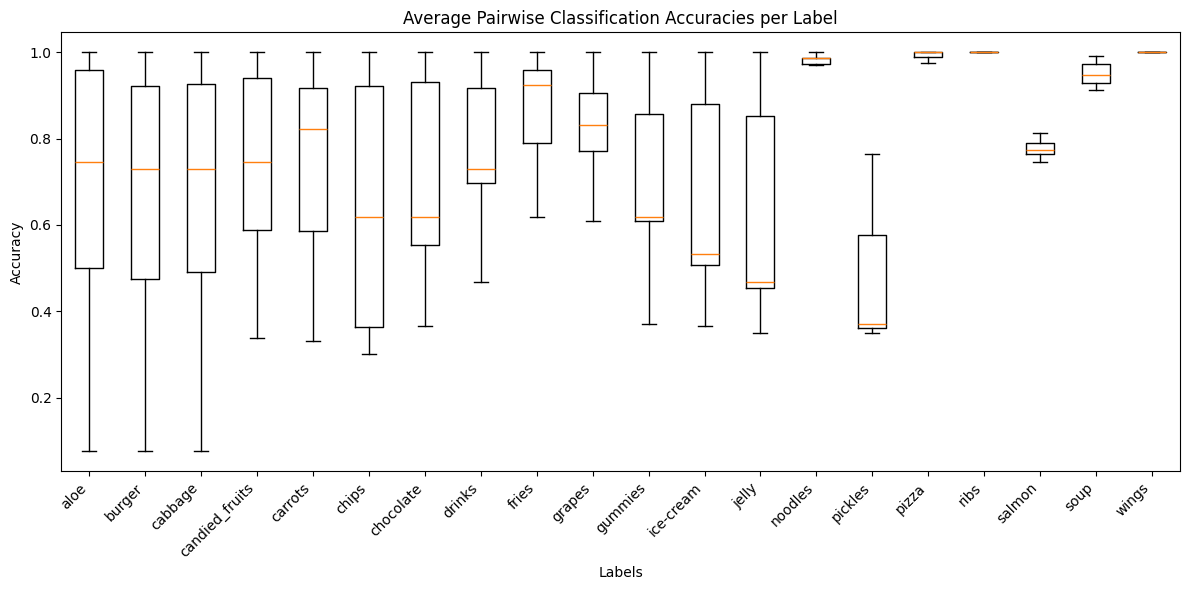

Top 10 Pairs with Highest Test Accuracies:
            Label1 Label2  Test Accuracy
14            aloe  pizza            1.0
15            aloe   ribs            1.0
18            aloe  wings            1.0
32          burger  pizza            1.0
33          burger   ribs            1.0
49         cabbage  pizza            1.0
50         cabbage   ribs            1.0
53         cabbage  wings            1.0
66  candied_fruits   ribs            1.0
69  candied_fruits  wings            1.0

Top 10 Pairs with Lowest Test Accuracies:
             Label1   Label2  Test Accuracy
1              aloe  cabbage       0.075472
19           burger  cabbage       0.075472
39          cabbage    chips       0.301471
4              aloe    chips       0.308824
22           burger    chips       0.330882
70          carrots    chips       0.330882
55   candied_fruits    chips       0.338235
13             aloe  pickles       0.349462
31           burger  pickles       0.349462
163           jelly  pi

In [24]:
# Collect results into a DataFrame for easier processing
pairwise_results = []
for pair, metrics in results.items():
    pairwise_results.append({
        "Label1": pair[0],
        "Label2": pair[1],
        "Train Accuracy": metrics['train_accuracy'],
        "Val Accuracy": metrics['val_accuracy'],
        "Test Accuracy": metrics['test_accuracy']
    })

results_df = pd.DataFrame(pairwise_results)

# Create boxplots for average pairwise classification performances per label
labels = df['label'].unique()
accuracy_per_label = {label: [] for label in labels}

for _, row in results_df.iterrows():
    label1, label2 = row['Label1'], row['Label2']
    test_accuracy = row['Test Accuracy']
    accuracy_per_label[label1].append(test_accuracy)
    accuracy_per_label[label2].append(test_accuracy)

# Prepare data for boxplots
boxplot_data = [accuracies for label, accuracies in accuracy_per_label.items()]
label_names = list(accuracy_per_label.keys())

# Create the boxplot
plt.figure(figsize=(12, 6))
plt.boxplot(boxplot_data, labels=label_names, showfliers=False)
plt.xticks(rotation=45, ha="right")
plt.title("Average Pairwise Classification Accuracies per Label")
plt.ylabel("Accuracy")
plt.xlabel("Labels")
plt.tight_layout()
plt.show()

# Identify the top 10 pairs with highest and lowest test accuracies
top_10_highest = results_df.nlargest(10, 'Test Accuracy')[['Label1', 'Label2', 'Test Accuracy']]
top_10_lowest = results_df.nsmallest(10, 'Test Accuracy')[['Label1', 'Label2', 'Test Accuracy']]

# Print top 10 pairs with highest and lowest accuracies
print("Top 10 Pairs with Highest Test Accuracies:")
print(top_10_highest)

print("\nTop 10 Pairs with Lowest Test Accuracies:")
print(top_10_lowest)


C:\Users\Snoop\AppData\Local\Temp\ipykernel_20848\1646776089.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=label_names, showfliers=False)


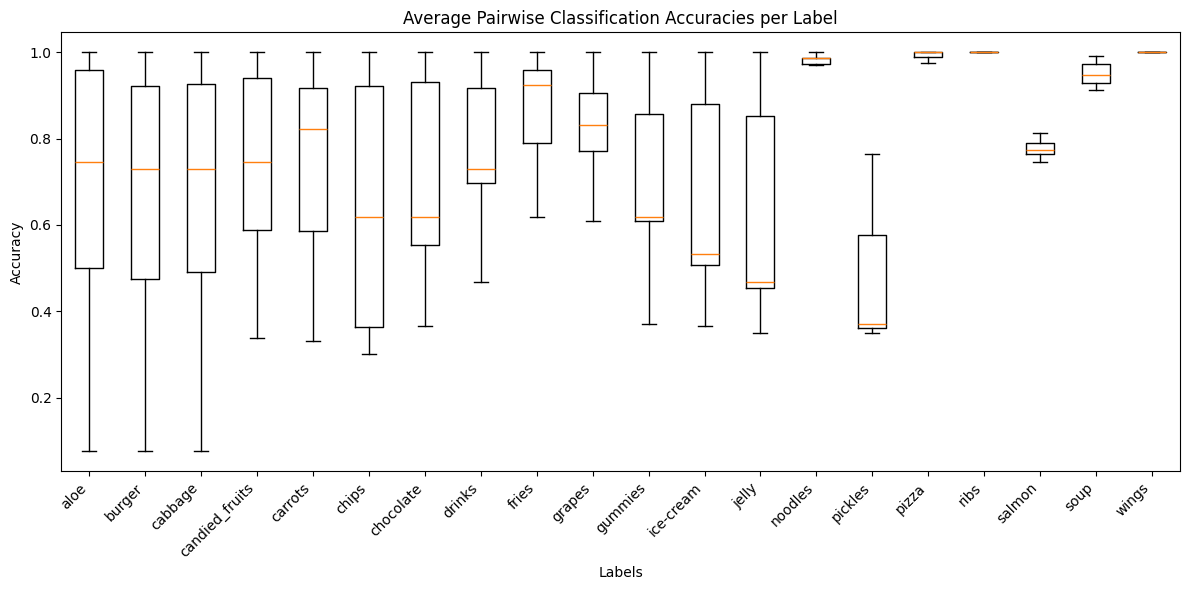

Top 10 Pairs with Highest Test Accuracies:
            Label1 Label2  Test Accuracy
14            aloe  pizza            1.0
15            aloe   ribs            1.0
18            aloe  wings            1.0
32          burger  pizza            1.0
33          burger   ribs            1.0
49         cabbage  pizza            1.0
50         cabbage   ribs            1.0
53         cabbage  wings            1.0
66  candied_fruits   ribs            1.0
69  candied_fruits  wings            1.0

Top 10 Pairs with Lowest Test Accuracies:
             Label1   Label2  Test Accuracy
1              aloe  cabbage       0.075472
19           burger  cabbage       0.075472
39          cabbage    chips       0.301471
4              aloe    chips       0.308824
22           burger    chips       0.330882
70          carrots    chips       0.330882
55   candied_fruits    chips       0.338235
13             aloe  pickles       0.349462
31           burger  pickles       0.349462
163           jelly  pi

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from itertools import combinations

# Collect results into a DataFrame for easier processing
pairwise_results = []
for pair, metrics in results.items():
    pairwise_results.append({
        "Label1": pair[0],
        "Label2": pair[1],
        "Train Accuracy": metrics['train_accuracy'],
        "Val Accuracy": metrics['val_accuracy'],
        "Test Accuracy": metrics['test_accuracy']
    })

results_df = pd.DataFrame(pairwise_results)

# Create boxplots for average pairwise classification performances per label
labels = df['label'].unique()
accuracy_per_label = {label: [] for label in labels}

for _, row in results_df.iterrows():
    label1, label2 = row['Label1'], row['Label2']
    test_accuracy = row['Test Accuracy']
    accuracy_per_label[label1].append(test_accuracy)
    accuracy_per_label[label2].append(test_accuracy)

# Prepare data for boxplots
boxplot_data = [accuracies for label, accuracies in accuracy_per_label.items()]
label_names = list(accuracy_per_label.keys())

# Create the boxplot
plt.figure(figsize=(12, 6))
plt.boxplot(boxplot_data, labels=label_names, showfliers=False)
plt.xticks(rotation=45, ha="right")
plt.title("Average Pairwise Classification Accuracies per Label")
plt.ylabel("Accuracy")
plt.xlabel("Labels")
plt.tight_layout()
plt.show()

# Identify the top 10 pairs with highest and lowest test accuracies
top_10_highest = results_df.nlargest(10, 'Test Accuracy')[['Label1', 'Label2', 'Test Accuracy']]
top_10_lowest = results_df.nsmallest(10, 'Test Accuracy')[['Label1', 'Label2', 'Test Accuracy']]
close_to_50 = results_df[(results_df['Test Accuracy'] >= 0.45) & (results_df['Test Accuracy'] <= 0.55)]

# Print top 10 pairs with highest and lowest accuracies
print("Top 10 Pairs with Highest Test Accuracies:")
print(top_10_highest)

print("\nTop 10 Pairs with Lowest Test Accuracies:")
print(top_10_lowest)

print("\nPairs with Test Accuracies Close to 50% (+/-5):")
print(close_to_50[['Label1', 'Label2', 'Test Accuracy']])

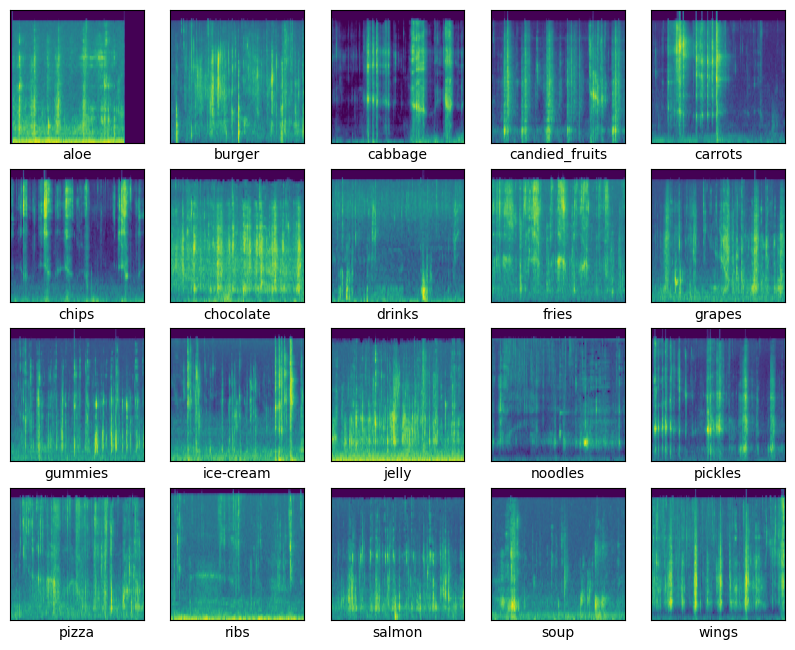

In [45]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
idx = [1, 1007, 1500, 2100, 3000, 3500, 4000, 4400, 5000, 
       5600, 6300, 7000, 7300, 7800, 8700, 9300, 9800, 10300, 
       10600, 11000]

dir_path = os.getcwd()
food_ds = FoodAudioDS(df, dir_path)
plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    sgram = food_ds[idx[i]][0]
    s_spec = sgram.squeeze().numpy()
    plt.imshow(s_spec, aspect='auto', origin='lower')
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(food_categories[food_ds[idx[i]][1]])
plt.show()

In [ ]:
idx = [1, 1007, 1500, 2100, 3000, 3500, 4000, 4400, 5000, 5600, 6300, 7000, 7300, 7800, 8700, 9300, 9800, 10300, 10600, 11000]


(tensor([[[-44.8984, -44.8984, -44.8984,  ..., -44.8984, -44.8984, -44.8984],
          [-44.8984, -44.8984, -44.8984,  ..., -44.8984, -44.8984, -44.8984],
          [-44.8984, -44.8984, -44.8984,  ..., -44.8984, -44.8984, -44.8984],
          ...,
          [-44.8984, -44.8984, -44.8984,  ..., -44.8984, -44.8984, -44.8984],
          [-44.8984, -44.8984, -44.8984,  ..., -44.8984, -44.8984, -44.8984],
          [-44.8984, -44.8984, -44.8984,  ..., -44.8984, -44.8984, -44.8984]]]),
 np.int64(0))

In [42]:
for idx, (label1, label2) in enumerate(combinations(df['label'].unique(), 2)):
    print(idx, label1)

0 aloe
1 aloe
2 aloe
3 aloe
4 aloe
5 aloe
6 aloe
7 aloe
8 aloe
9 aloe
10 aloe
11 aloe
12 aloe
13 aloe
14 aloe
15 aloe
16 aloe
17 aloe
18 aloe
19 burger
20 burger
21 burger
22 burger
23 burger
24 burger
25 burger
26 burger
27 burger
28 burger
29 burger
30 burger
31 burger
32 burger
33 burger
34 burger
35 burger
36 burger
37 cabbage
38 cabbage
39 cabbage
40 cabbage
41 cabbage
42 cabbage
43 cabbage
44 cabbage
45 cabbage
46 cabbage
47 cabbage
48 cabbage
49 cabbage
50 cabbage
51 cabbage
52 cabbage
53 cabbage
54 candied_fruits
55 candied_fruits
56 candied_fruits
57 candied_fruits
58 candied_fruits
59 candied_fruits
60 candied_fruits
61 candied_fruits
62 candied_fruits
63 candied_fruits
64 candied_fruits
65 candied_fruits
66 candied_fruits
67 candied_fruits
68 candied_fruits
69 candied_fruits
70 carrots
71 carrots
72 carrots
73 carrots
74 carrots
75 carrots
76 carrots
77 carrots
78 carrots
79 carrots
80 carrots
81 carrots
82 carrots
83 carrots
84 carrots
85 chips
86 chips
87 chips
88 chips
89

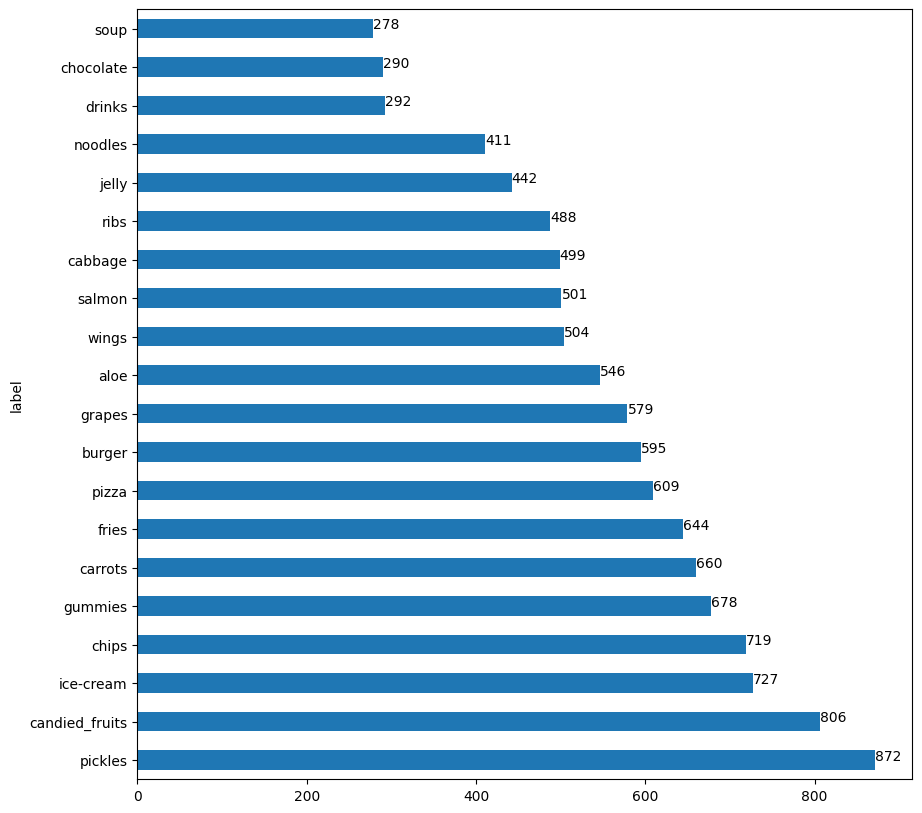

In [77]:
plt.figure(figsize=(10,10))
counts = df['label'].value_counts()
counts.plot(kind='barh')

for index, value in enumerate(df['label'].value_counts()):
    plt.text(value, index,
             str(value))
# plt.xlabel('Category')
# plt.ylabel('Count')
# plt.title('Value Counts of Categories')
plt.show()


['aloe',
 'burger',
 'cabbage',
 'candied_fruits',
 'carrots',
 'chips',
 'chocolate',
 'drinks',
 'fries',
 'grapes',
 'gummies',
 'ice-cream',
 'jelly',
 'noodles',
 'pickles',
 'pizza',
 'ribs',
 'salmon',
 'soup',
 'wings']

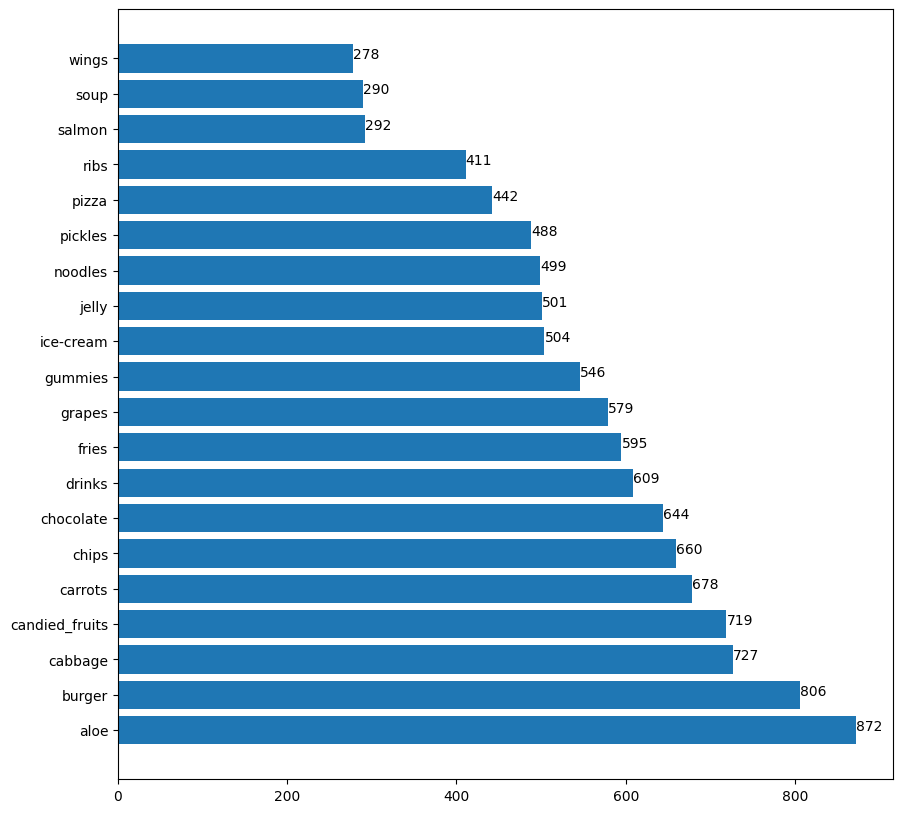

In [73]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], va = 'center')

plt.figure(figsize=(10,10))
plt.barh(food_categories, df['label'].value_counts())

for index, value in enumerate(df['label'].value_counts()):
    plt.text(value, index,
             str(value))
plt.show()